In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

while 'jupyter' in os.getcwd():
    os.chdir("../")

!pwd

/Users/msat/projects/white-box-nn


In [118]:
import torch
from torch import einsum, nn
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F

import pandas as pd
import seaborn as sn
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import kornia
from kornia.geometry.transform import affine, translate, rotate
from kornia.enhance import adjust_brightness, adjust_contrast, adjust_hue, adjust_saturation, adjust_gamma

from art.attacks.evasion import FastGradientMethod, AutoAttack, AutoProjectedGradientDescent, SquareAttack, BoundaryAttack
from art.estimators.classification import PyTorchClassifier

from lib.datamodules import MNISTDataModule
from lib.helpers import hh, normalize_weight_, normalize_weight
from lib.lightning_modules.cls_module import ClsModule

from lib.modules.augment import Noise
from lib.modules.sf_layers import AffineLayer, TwoStepFunction, ConvLayer
from lib.modules.sf_samplers import SFSampler, AffineSampler, RotationSampler

BATCH_SIZE = 200

# LABELS = None
# LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
LABELS = [3, 5]
N_CLASSES = len(LABELS) if LABELS else 10
# CIFAR = True
CIFAR = False

# dtype = torch.cfloat
# dtype = torch.float32

prefix = "mnist"
IMG_SHAPE = (1, 28, 28)
EPS = 0.3
STEP_SIZE = 0.1
NORMALIZATION = transforms.Normalize((0.1307,), (0.3081,))

DIM_INPUT = torch.prod(torch.tensor(IMG_SHAPE))
LOGS_DIR = f"logs/{prefix}_sf_model/"

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [120]:
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, labels=LABELS, shape=IMG_SHAPE[1:])

datamodule.prepare_data()
datamodule.setup()

In [121]:
n_samples = 50
n_skip = 0
# n_samples = 200
# n_samples = 10000
iter_ = iter(datamodule.test_dataloader(n_samples))

for _ in range(n_skip):
    next(iter_)
x_test, y_test = next(iter_)
x_test = x_test.to(device)

In [122]:
dataitem = next(iter(datamodule.val_dataloader()))
data, target = dataitem

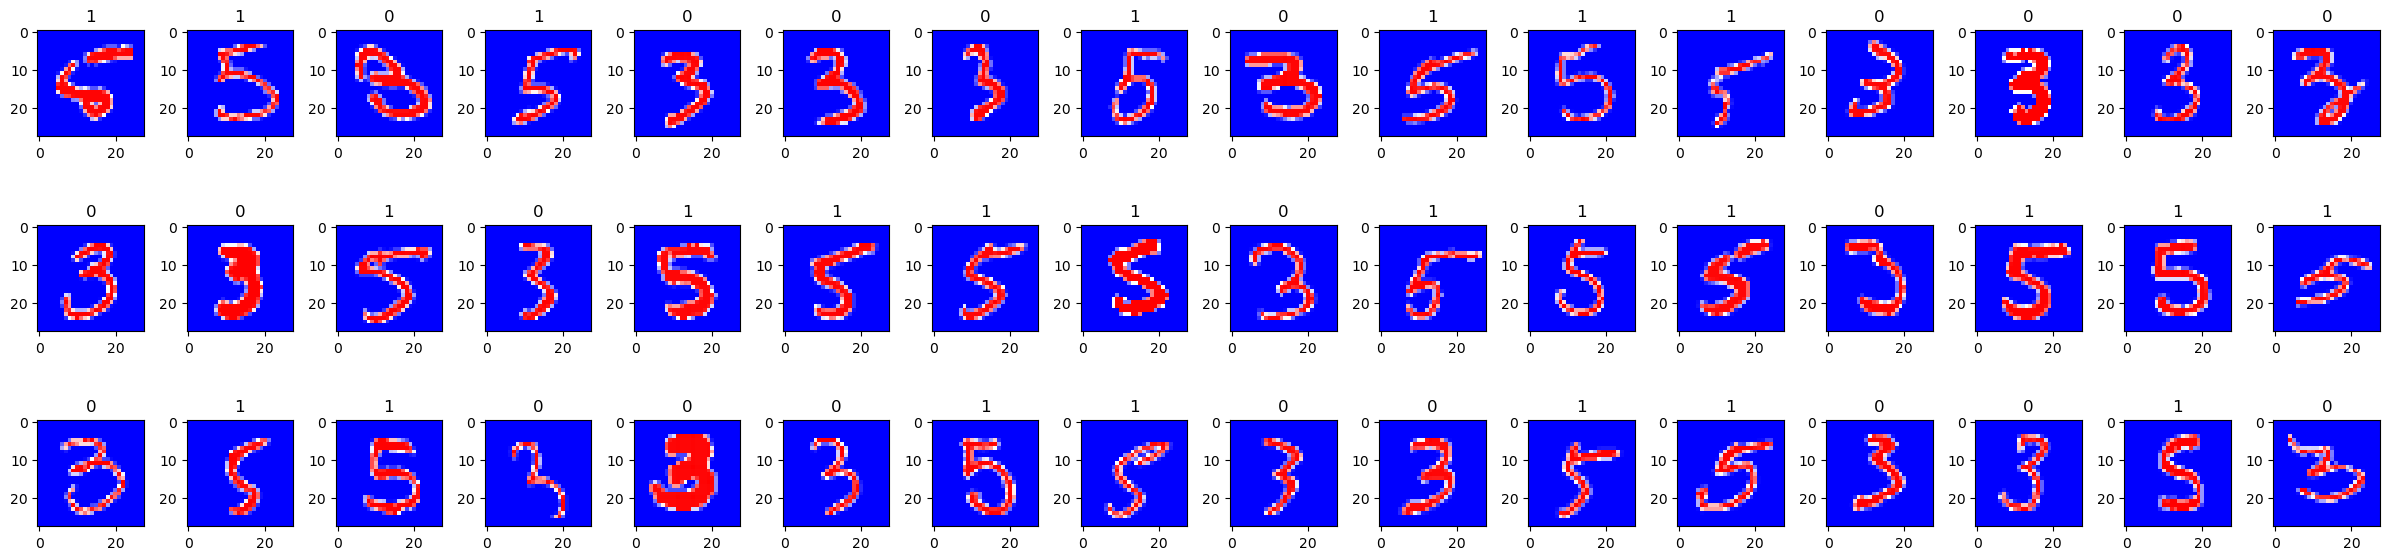

In [123]:
hh.plot_example(x_test, y_test)

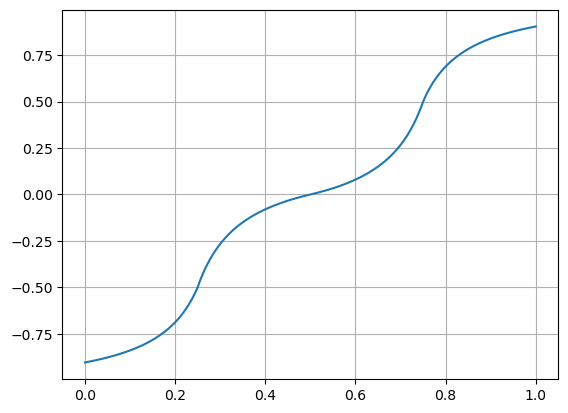

In [621]:
func = TwoStepFunction(5)

n_steps = 1000
thr = torch.tensor(range(n_steps + 1)) / n_steps

vval = func(thr)
plt.plot(thr, vval.detach())

ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Train

In [921]:
seed = 314
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

augment = nn.Sequential(
    Noise(mean=0.05, scale=0.25, clip=True, p=0.7),
)

latent_dim = 2

pixel_layer = TwoStepFunction(10)

conv_layer = ConvLayer(
    sampler=RotationSampler(16),
    n_kernels=2,
    kernel_size=5,
    act=nn.ReLU(),
    # add_bias=True,
    add_bias=False,
)

affine_layer = AffineLayer(
    sampler=AffineSampler(32, dim_pose_group=latent_dim),
    inp_shape=IMG_SHAPE,
    # inp_shape=(2, 28, 28),
    feature_shape=(1, 18, 18),
    # feature_shape=(2, 18, 18),
    out_dim=latent_dim,
    act=nn.ReLU(),
    # add_bias=True,
    add_bias=False,
)

lin = nn.Linear(latent_dim, N_CLASSES, bias=False)
with torch.no_grad():
    w = lin.weight
    nn.init.eye_(w)
    w.add_(-0.5)
    w.mul_(2.)

backbone = nn.Sequential(OrderedDict([
    ('pixel', pixel_layer),
    ('conv', conv_layer),
    ('aff', affine_layer),
    ('head', lin),
]))

model = ClsModule(
    learning_rate=3e-3, # BEST
    # weight_decay=3e-7,# 0.00001,
    # weight_decay=3e-6,# BEST?
    weight_decay=0.0,
    noise_eps=EPS,
    adv_prob=0.,
    # adv_prob=1.0,
    val_adv_prob=1.0,
    n_classes=N_CLASSES,
    augment=augment,
    backbone=backbone,
)

bb = model.backbone
model(data) # to initialize cls_head
pass

In [922]:
batch_size = BATCH_SIZE
# batch_size = 1
datamodule = MNISTDataModule(batch_size=batch_size, labels=LABELS, shape=IMG_SHAPE[1:])

version = 0
trainer = Trainer(
    accelerator="auto",
    # precision=16,
    # devices=1 if torch.cuda.is_available() else None,
    devices="auto",
    # max_epochs=2,
    # max_epochs=3,
    # max_epochs=5,
    # max_epochs=10,
    max_epochs=15,
    # max_epochs=20,
    # max_epochs=30,
    callbacks=[TQDMProgressBar(refresh_rate=2)],
    logger=CSVLogger(save_dir=LOGS_DIR, version=version),
)

trainer.fit(
    model=model,
    datamodule=datamodule,
    # ckpt_path=f"{LOGS_DIR}lightning_logs/version_{version}/checkpoints/epoch=9-step=1130.ckpt",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/mnist_sf_model/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type               | Params
------------------------------------------------------
0 | loss           | CrossEntropyLoss   | 0     
1 | augment        | Sequential         | 0     
2 | backbone       | Sequential         | 1.1 K 
3 | train_accuracy | MulticlassAccuracy | 0     
4 | val_accuracy   | MulticlassAccuracy | 0     
5 | test_accuracy  | MulticlassAccuracy | 0     
6 | corr_avg_conf  | MeanMetric         | 0     
7 | miss_avg_conf  | MeanMetric         | 0     
8 | miss_max_conf  | MaxMetric      

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [923]:
model.to(device)
model.eval()
trainer.test(model, datamodule)
model.eval()
model.training

/usr/local/Caskroom/miniconda/base/envs/quale/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      corr_avg_conf          0.930820643901825
      miss_avg_conf         0.7529891133308411
      miss_max_conf         0.9969183206558228
      test_adv_acc          0.9216614365577698
      test_adv_loss         0.20614998042583466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


False

,train_loss,train_acc,val_adv_loss,val_adv_acc,test_adv_loss,test_adv_acc,corr_avg_conf,miss_avg_conf,miss_max_conf
epoch,,,,,,,,,
11,0.033184,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,0.212836,0.922187,NaN,NaN,NaN,NaN,NaN
12,0.027458,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.035050,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,0.211933,0.923239,NaN,NaN,NaN,NaN,NaN
13,0.040652,0.985,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,0.228296,0.912723,NaN,NaN,NaN,NaN,NaN
14,0.024373,0.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,0.209892,0.922187,NaN,NaN,NaN,NaN,NaN


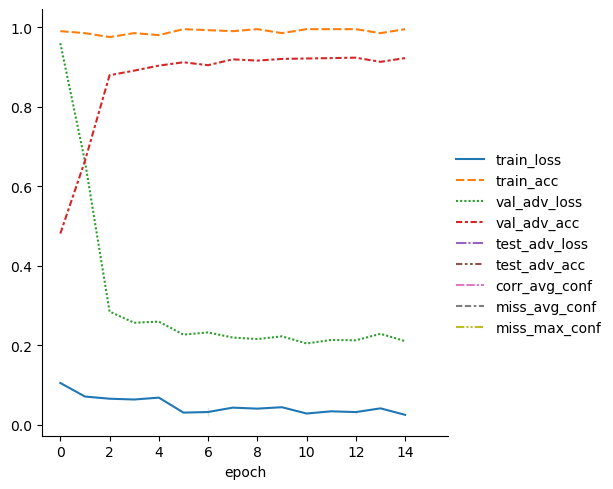

In [924]:
# 
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail(10))
met = metrics[metrics.index >= 0] # first few epochs might be an outliers
sn.relplot(data=met, kind="line")

In [941]:
len(bb)

4

In [ ]:
torch.split

In [987]:
def visualize_processing_steps(bb, x):
    x0 = bb[0](x)
    x1 = bb[1](x0)
    x2, f = bb[2](x1, with_features=True)
    x3 = bb[3](x2)

    f1, f2 = torch.split(f, 1, dim=1)

    y = [(round(scores[0].item(), ndigits=2), round(scores[1].item(), ndigits=2)) for scores in x2]
    y += [(round(scores[0].item(), ndigits=2), round(scores[1].item(), ndigits=2)) for scores in x3]
    y += [(round(scores[0].item(), ndigits=2), round(scores[1].item(), ndigits=2)) for scores in x3.softmax(dim=1)]
    y += [round(e.item(), ndigits=2) for e in x2[:, 0]]
    y += [round(e.item(), ndigits=2) for e in x2[:, 1]]

    ret = torch.cat([x, x0, x1, f1[:, 0], f2[:, 0]], dim=0)
    return ret, y

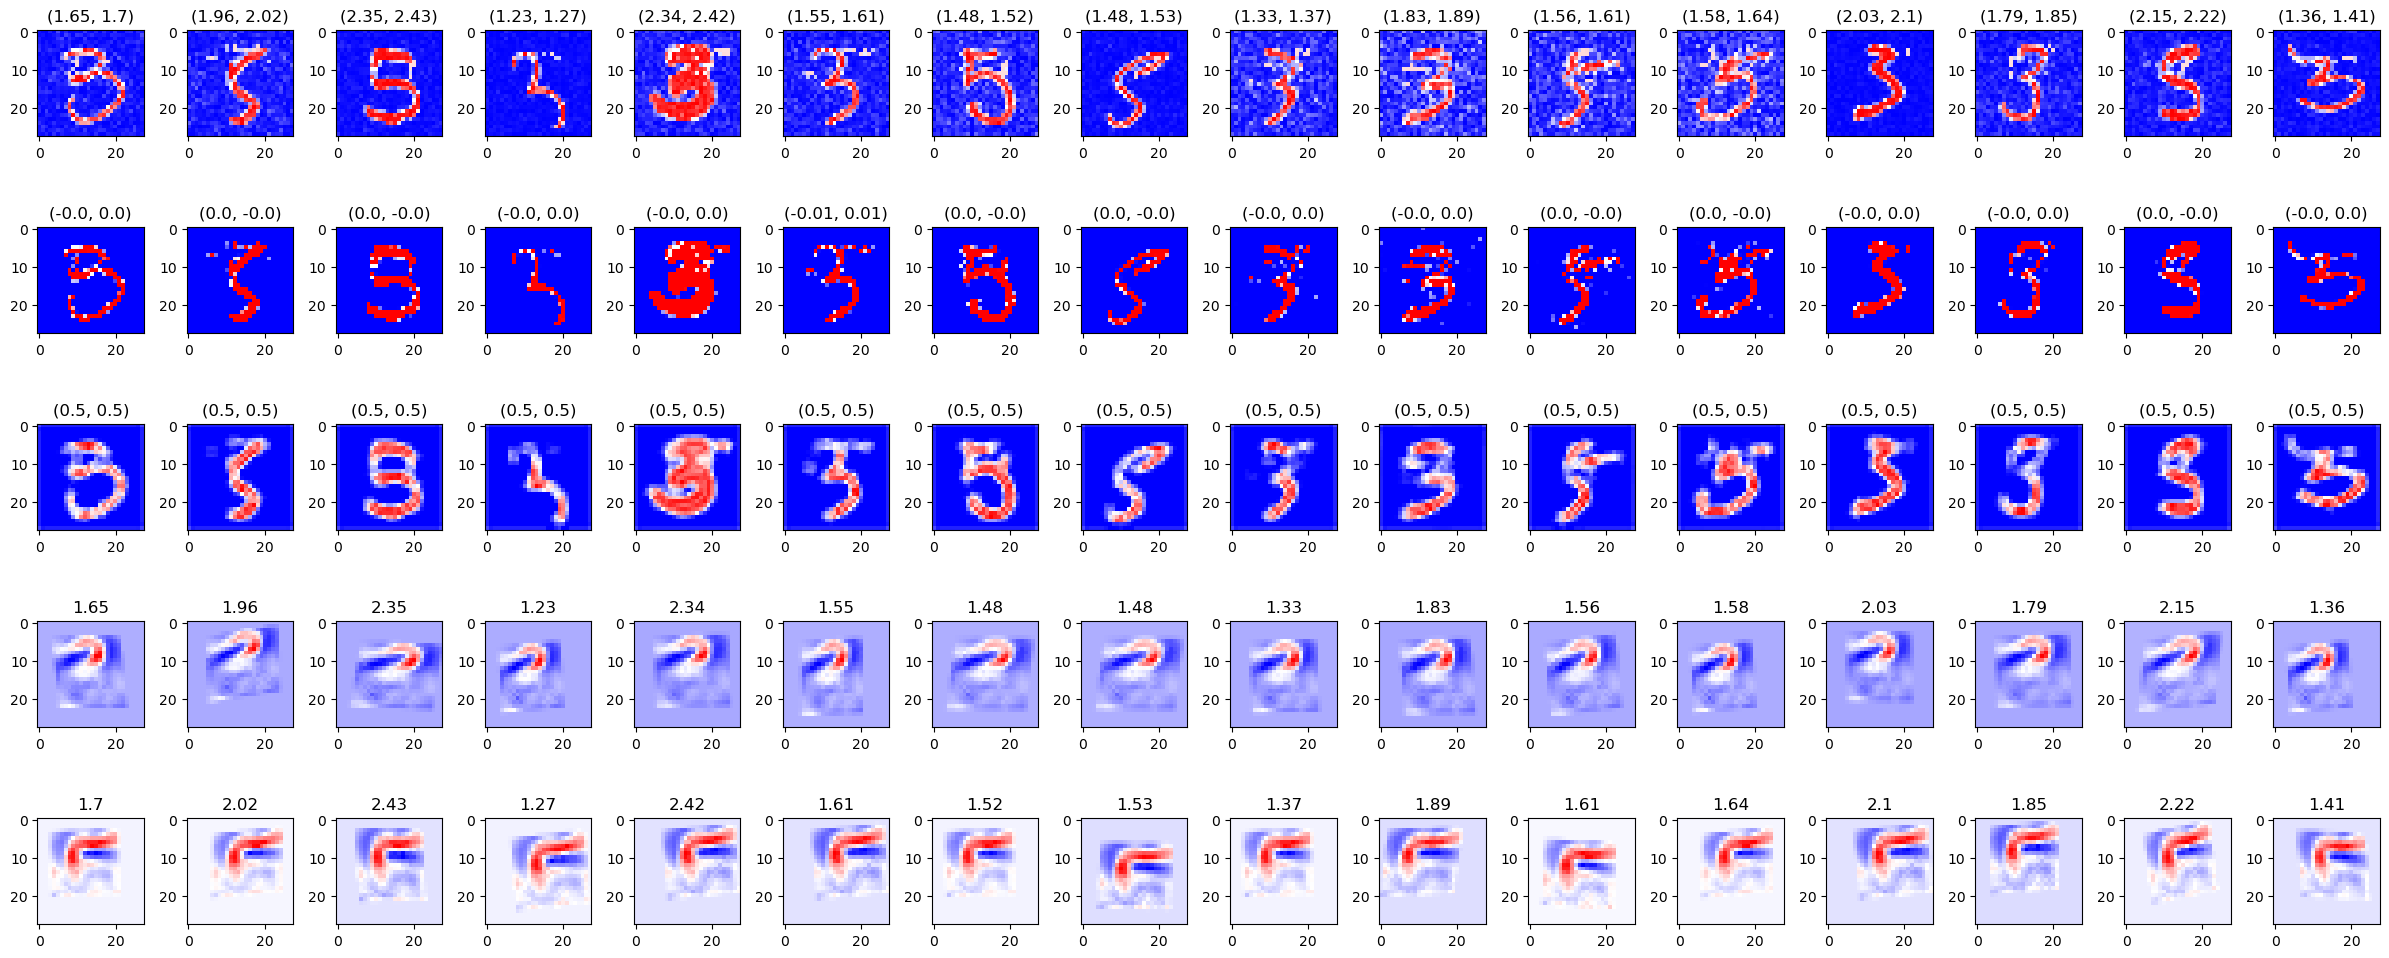

In [989]:
xx = x_test_adv[:16]
# xx = augment(x_test[:16])
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

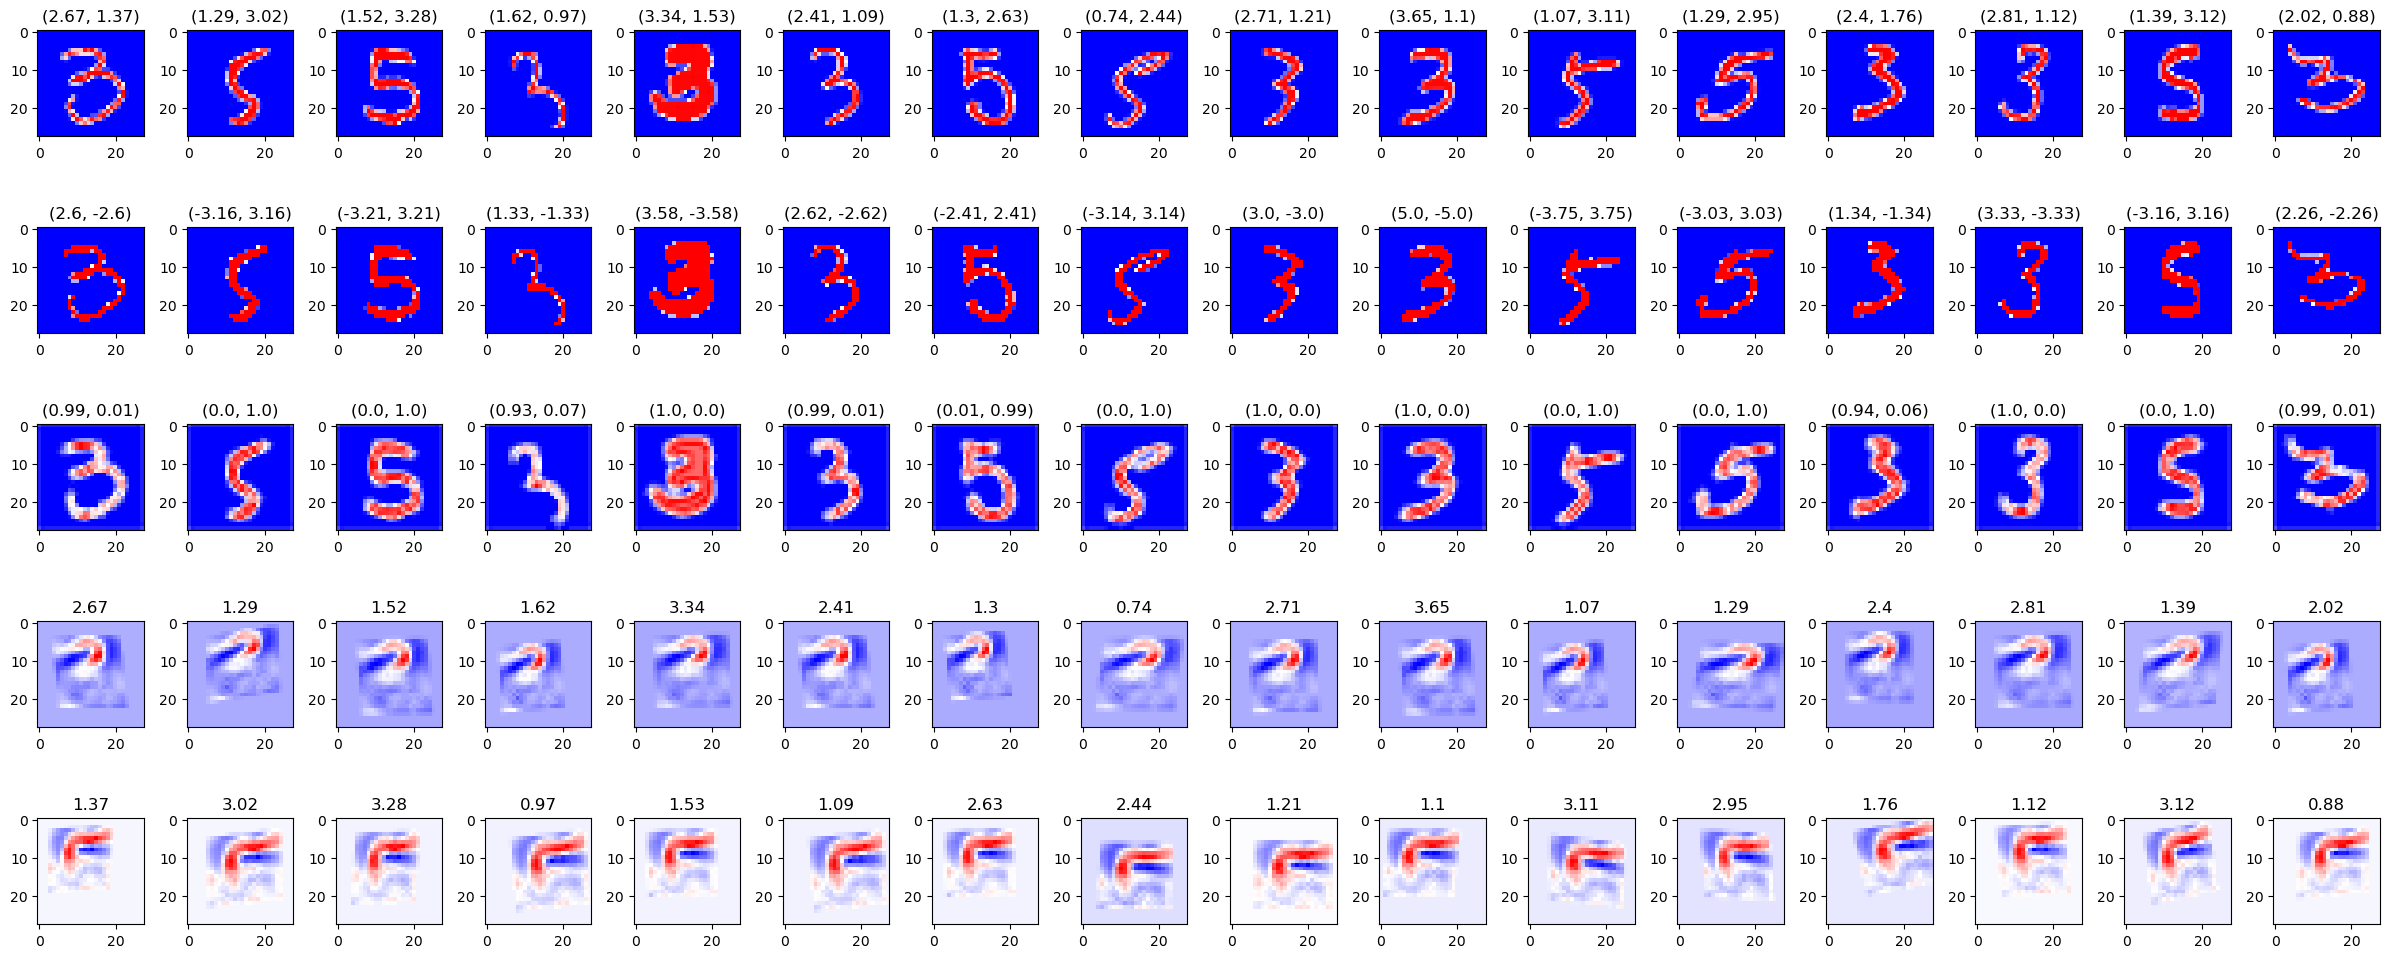

In [991]:
# xx = x_test_adv[:16]
# xx = augment(x_test[:16])
xx = x_test[32:48]
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

tensor(-0.1561, grad_fn=<MinBackward1>) tensor(0.2506, grad_fn=<MaxBackward1>)


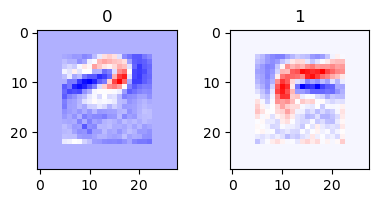

In [929]:
f = bb[2].get_features()

print(f.min(), f.max())

hh.plot_example(f, list(range(len(f))), n_col=2, n_row=1)

tensor(-0.2315) tensor(0.4214)


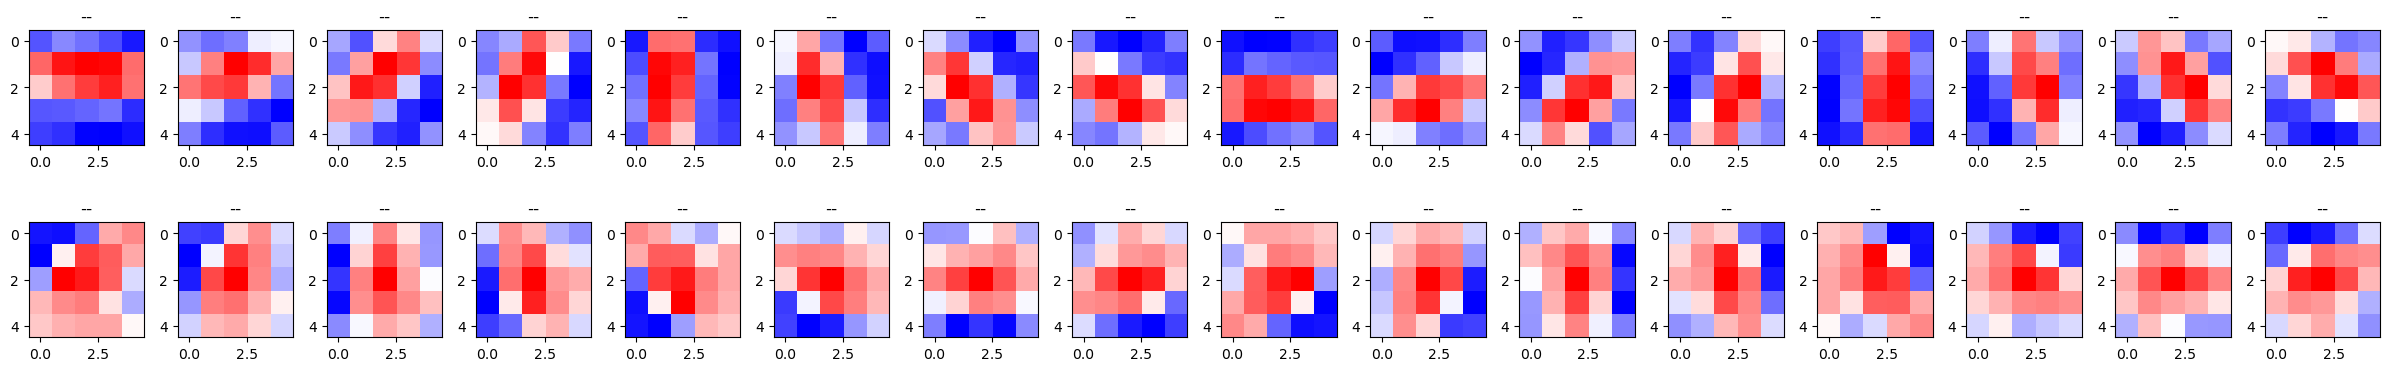

In [930]:
cc = bb[1].get_weight().detach().flatten(0, 1)
print(cc.min(), cc.max())

hh.plot_example(cc, n_row=2, n_col=16)

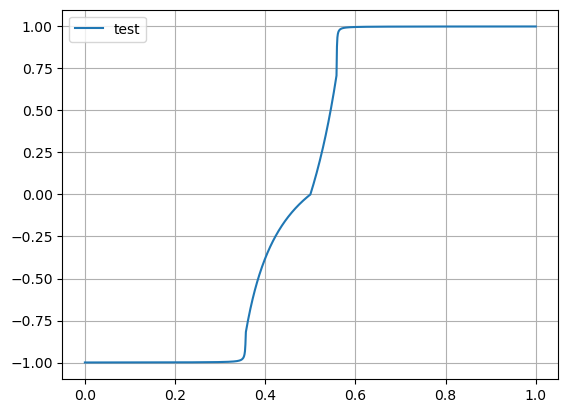

In [931]:
n_steps = 1000
thr = torch.tensor(range(n_steps + 1)) / n_steps

val = bb[0](thr)
plt.plot(thr, val.detach(), label='test')
plt.legend()

ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [932]:
bb[0].t0, bb[0].t1, bb[0].a0, bb[0].a1, bb[0].scales

(Parameter containing:
 tensor(0.3566, requires_grad=True),
 Parameter containing:
 tensor(0.5583, requires_grad=True),
 Parameter containing:
 tensor(0.8240, requires_grad=True),
 Parameter containing:
 tensor(0.7129, requires_grad=True),
 Parameter containing:
 tensor([0.0020, 0.1680, 0.2708, 0.0010], requires_grad=True))

In [933]:
bb[3].weight.round(decimals=2)

tensor([[ 1.9400, -1.8700],
        [-1.9400,  1.8700]], grad_fn=<RoundBackward1>)

In [934]:
# uf, df = bb.layer1.get_filters()
torch.norm(f.flatten(1), dim=1), torch.norm(cc.flatten(1), dim=1)

(tensor([1.0000, 1.0000], grad_fn=<LinalgVectorNormBackward0>),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

tensor(-0.4955, grad_fn=<MinBackward1>) tensor(0.8005, grad_fn=<MaxBackward1>)


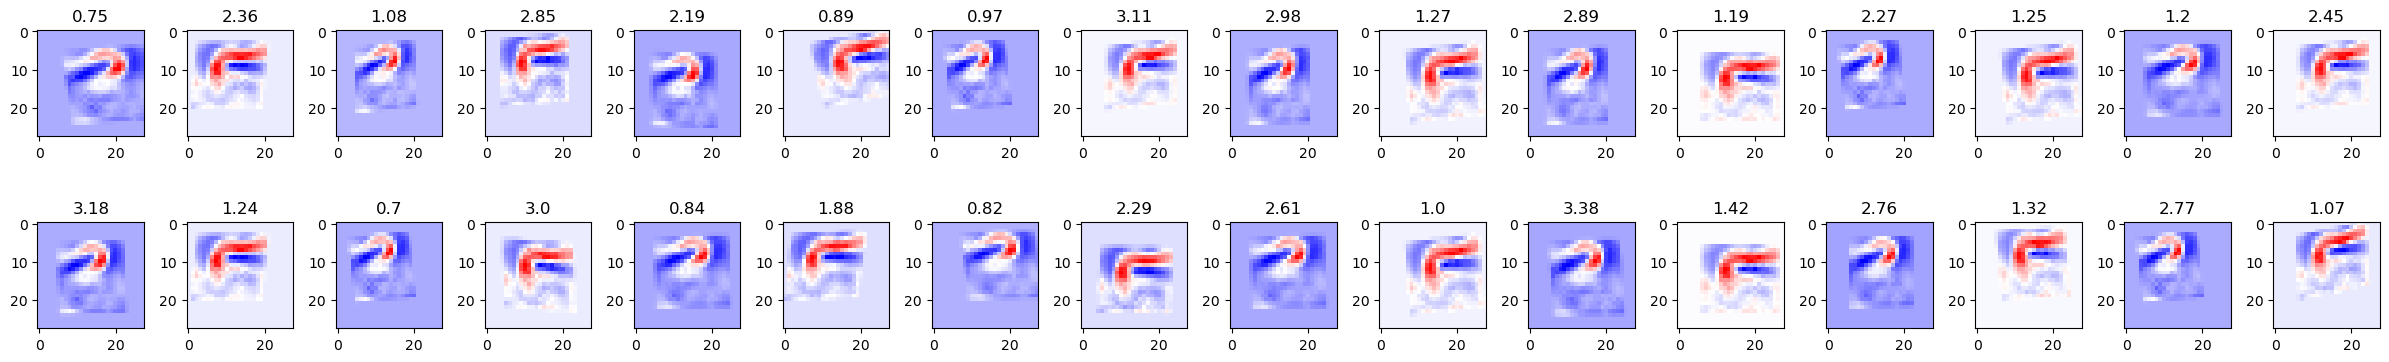

In [935]:
xx = x_test[:16].to(device)
xx = bb[:2](xx)
x, xw = bb[2](xx, with_features=True)

show = xw.unflatten(-1, IMG_SHAPE).flatten(0, 1)
# show = xw.unflatten(-1, IMG_SHAPE).flatten(0, 1)
print(show.min(), show.max())

max_rows = 16
hh.plot_example(show, [round(e.item(), 2) for e in x.flatten()], n_col=16, n_row=min(max(show.shape[0]//16, 2), max_rows))

In [936]:
xw.sum(dim=1).min(), xw.sum(dim=1).max()

(tensor(-0.5638, grad_fn=<MinBackward1>),
 tensor(0.9516, grad_fn=<MaxBackward1>))

torch.Size([64, 1, 28, 28])
tensor(-0.1735) tensor(0.2659)


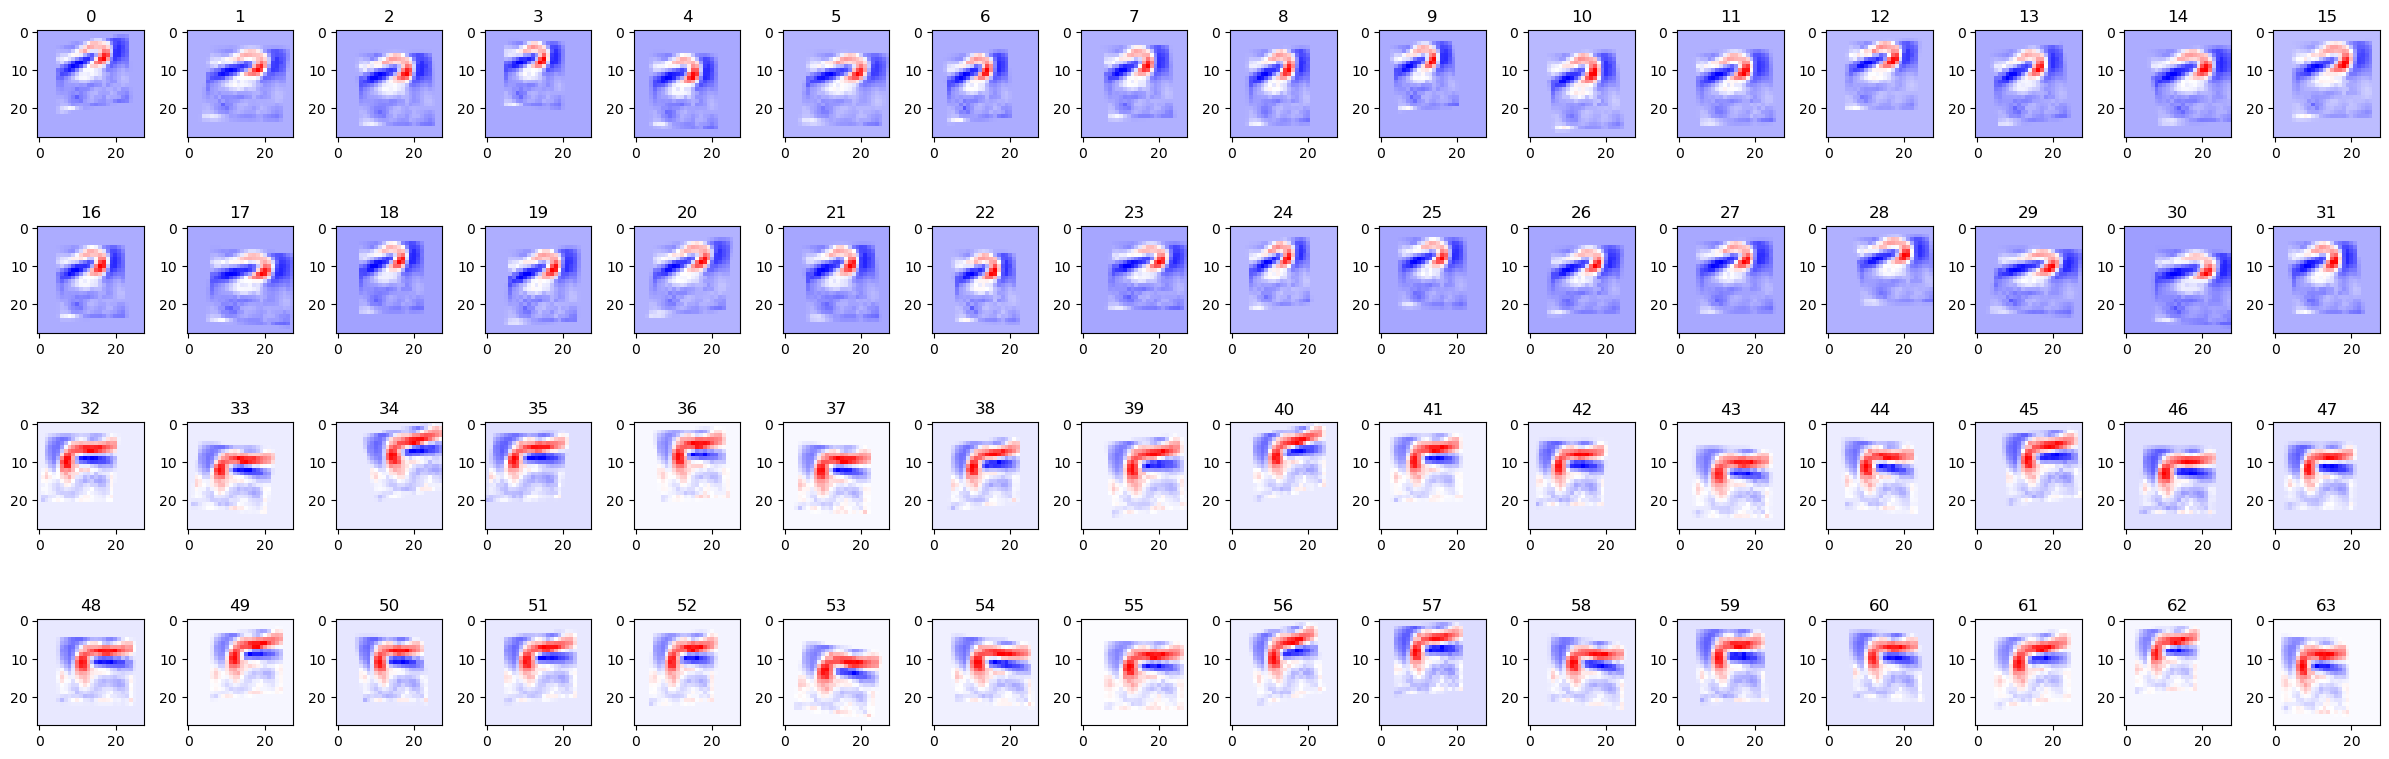

In [937]:
ff = bb[2].get_weight()
ff = ff.flatten(0, 1)

print(ff.shape)
print(ff.min(), ff.max())

max_rows = 16

hh.plot_example(ff, list(range(len(ff))), n_col=16, n_row=min(max(ff.shape[0]//16, 2), max_rows))

In [938]:
poses = torch.cat(list(bb[2].sampler.poses))
poses.round(decimals=2)
pass

In [939]:
poses[:, :, :2].min(), poses[:, :, :2].max(), poses.min(), poses.max()

(tensor(-0.2221, grad_fn=<MinBackward1>),
 tensor(1.1998, grad_fn=<MaxBackward1>),
 tensor(-2.6338, grad_fn=<MinBackward1>),
 tensor(3.0804, grad_fn=<MaxBackward1>))

In [ ]:
# block = model.backbone.col_layers[0]

# cutoff = 1
if False:
# if True:
    torch.save(block, f"models/music/block_{cutoff}.pt")
    torch.save(block.state_dict(), f"models/music/block_{cutoff}_state_dict.pt")
    
    # torch.save(block, f"models/music/block_{cutoff}_lin.pt")
    # torch.save(block.state_dict(), f"models/music/block_{cutoff}_state_dict_lin.pt")

In [ ]:
if False:
# if True:
    for i, block in enumerate(model.backbone.blocks):
        # block = torch.load(f"models/music/block_{i}.pt")
        print(i)
        # block_state_dict = torch.load(f"models/music/block_{i}_state_dict.pt", map_location=device)
        torch.save(block.state_dict(), f"models/music/mnist_block_{i}_state_dict.pt")
        # block_state_dict = torch.load(f"models/music/block_{i}_state_dict_lin.pt")
        # base[i].load_state_dict(block_state_dict)

# base

# Attack

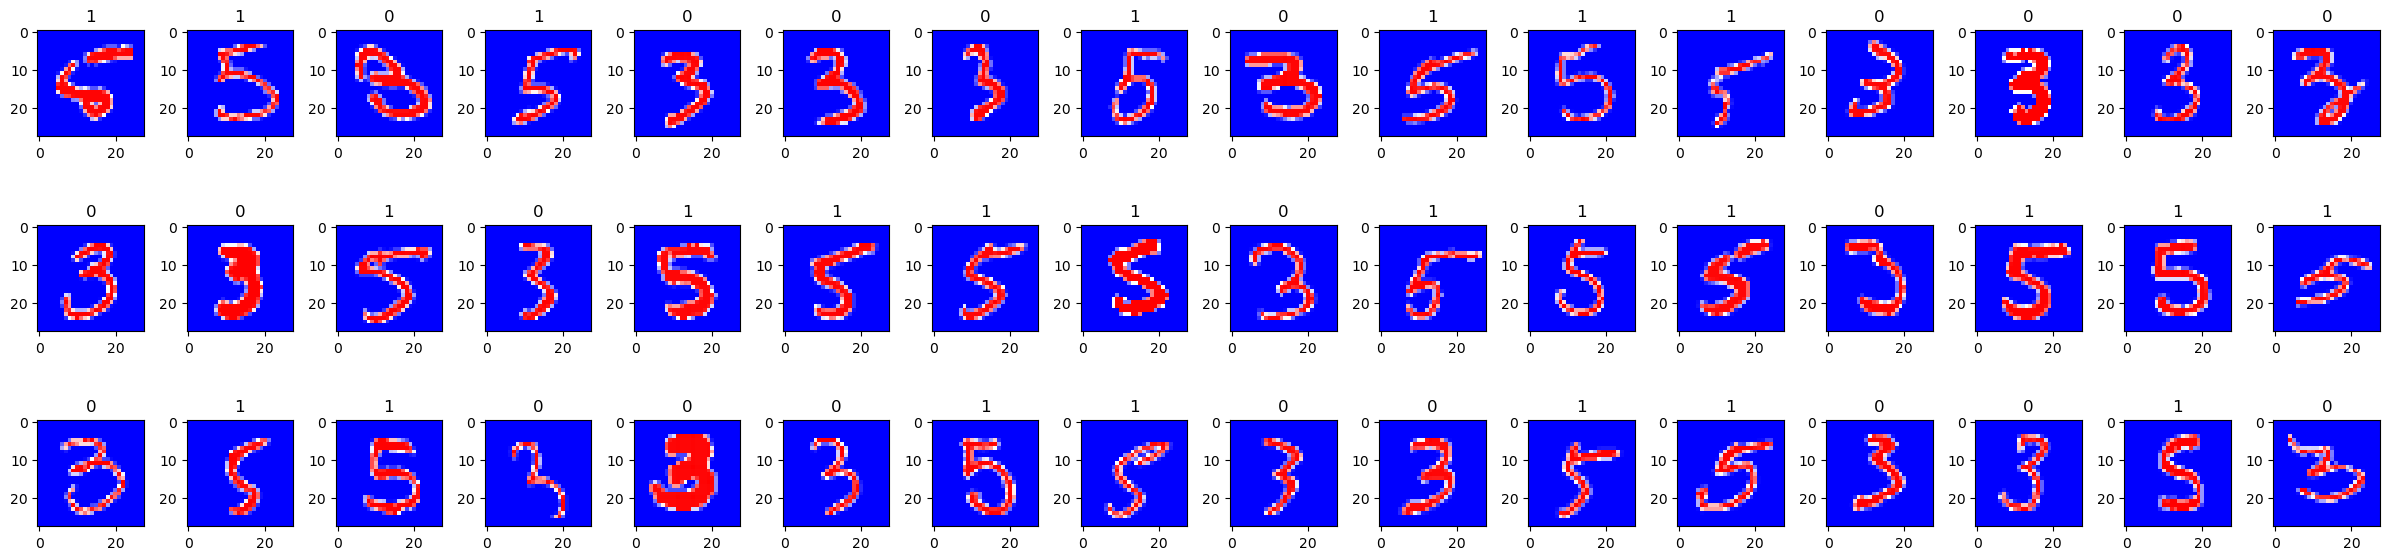

In [5375]:
hh.plot_example(x_test.cpu(), y_test)

In [5376]:
model.training

False

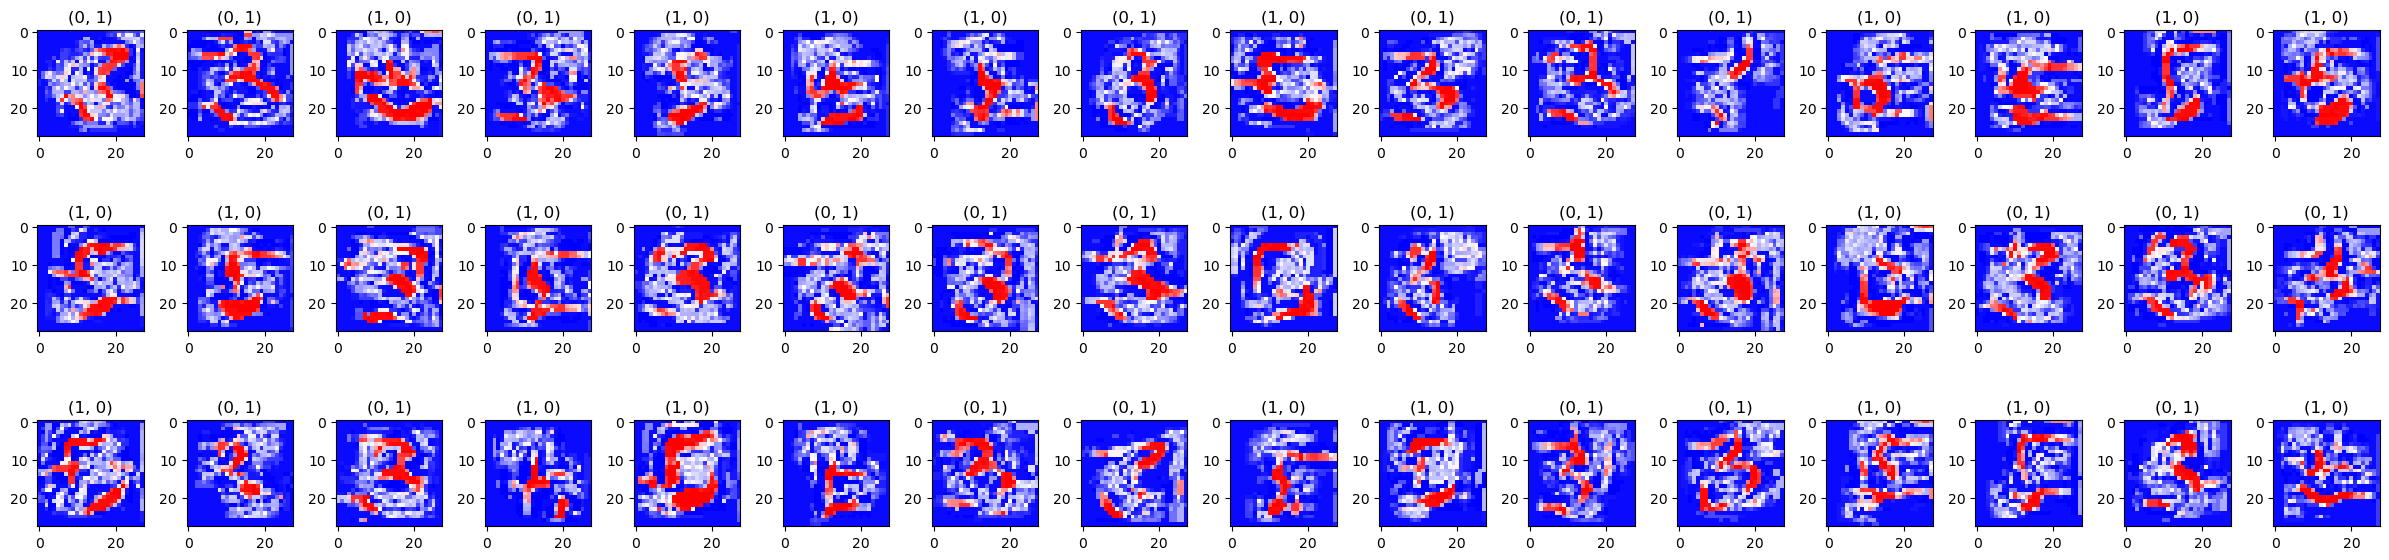

In [802]:
xx = x_test
y = torch.fmod(y_test + 1, N_CLASSES).to(device)
x = hh.compute_advs(model, xx, y, eps=0.9, step_size=0.02, Nsteps=60, minimize=True, random_start=False)

hh.plot_example(x.cpu(), list(zip(y.cpu().numpy(), y_test.cpu().numpy())))

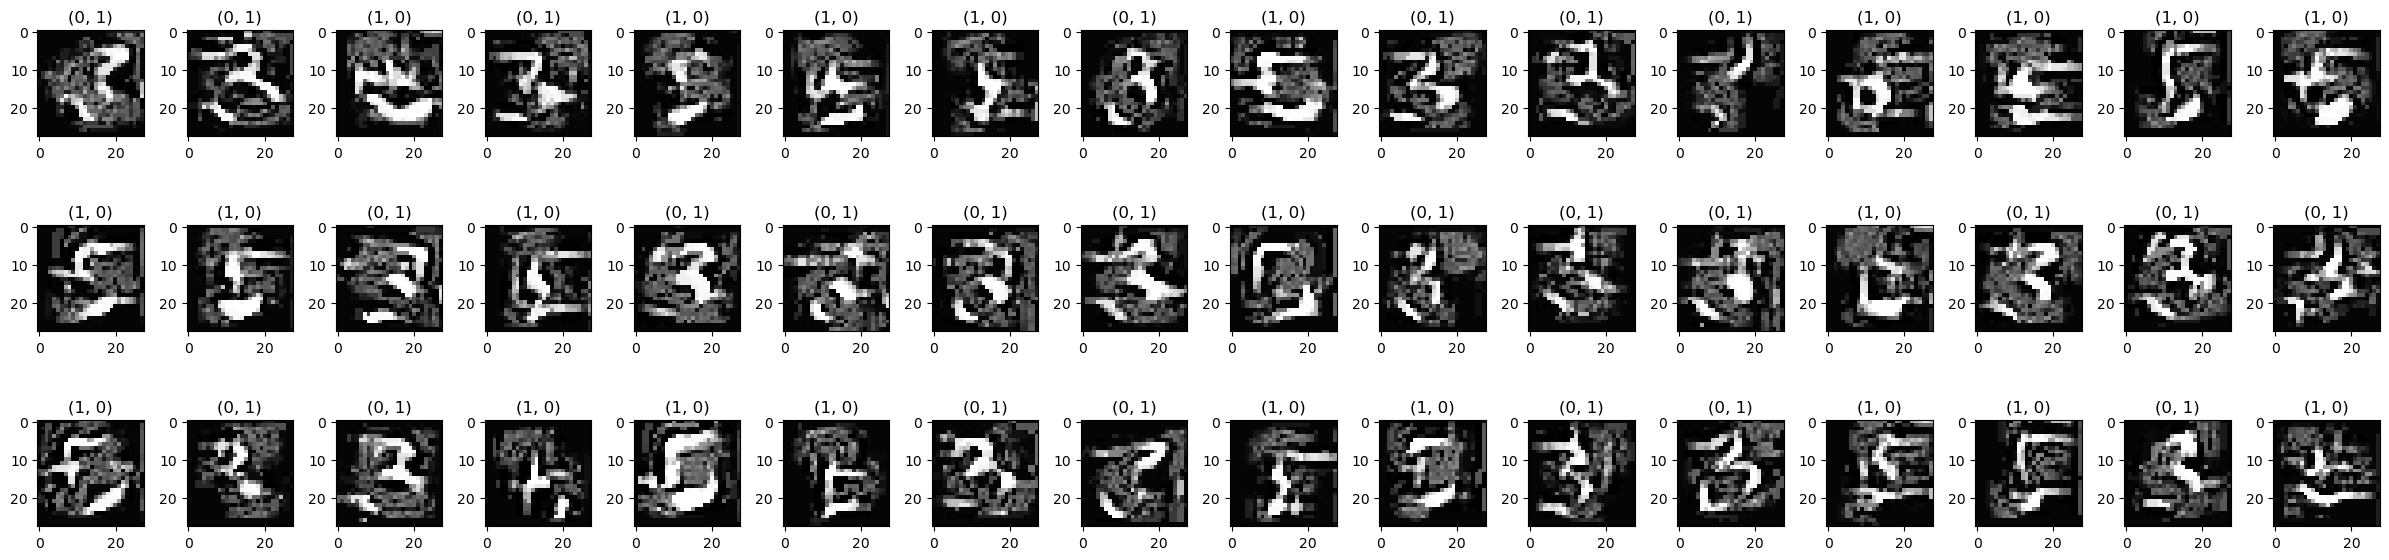

In [803]:
hh.plot_example(x.cpu(), list(zip(y.cpu().numpy(), y_test.cpu().numpy())), cmap="gray")

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 96.0%


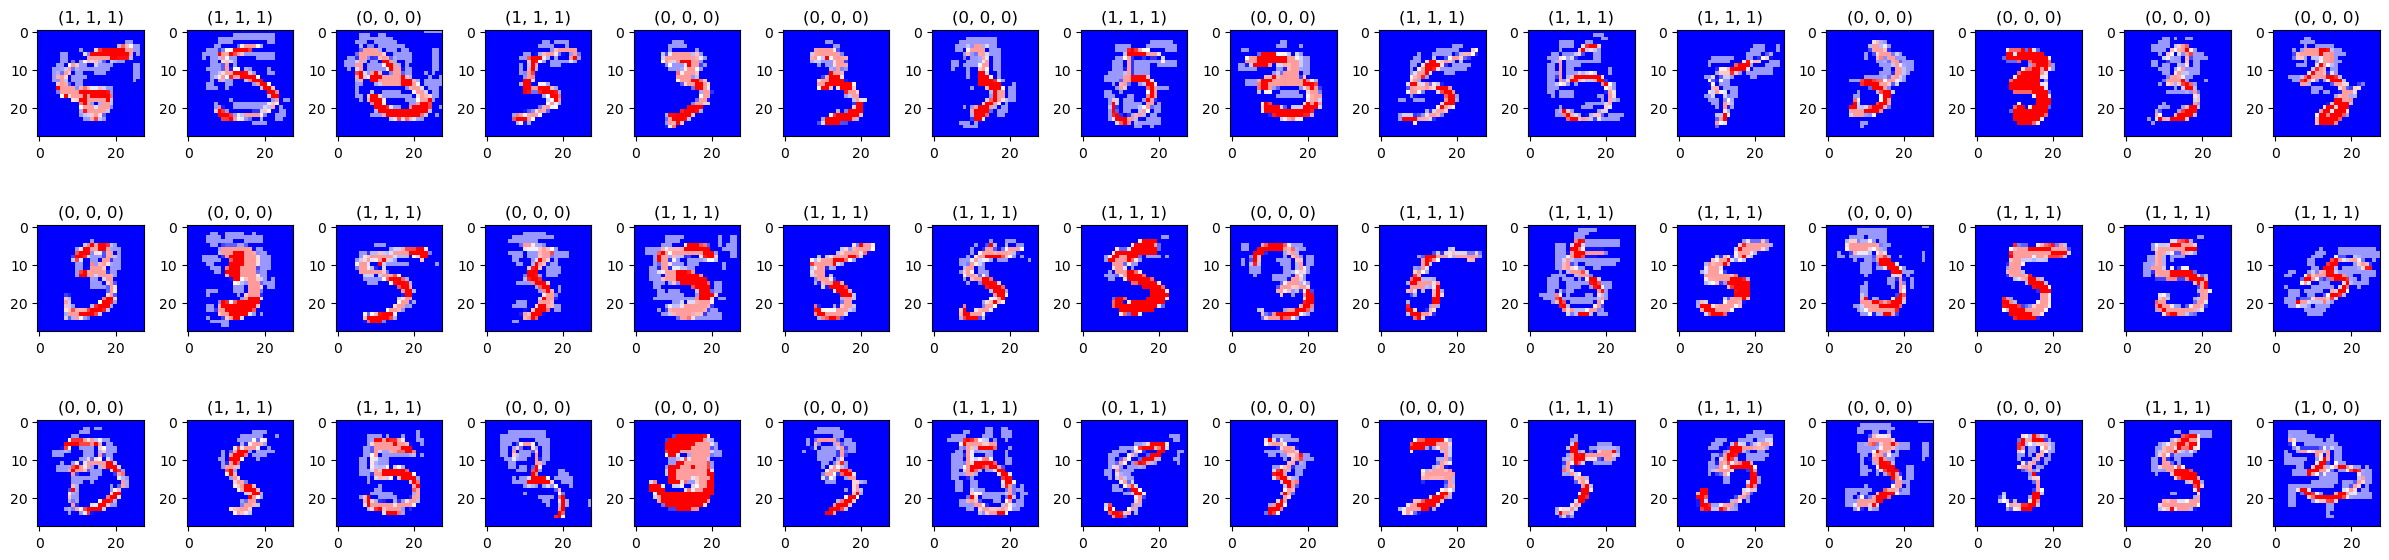

In [804]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=model.configure_optimizers(),
    input_shape=IMG_SHAPE,
    nb_classes=N_CLASSES,
)

# attack = FastGradientMethod(estimator=classifier, eps=3, norm=2, eps_step=0.5, targeted=True)#, eps_step=0.01)
# attack = FastGradientMethod(estimator=classifier, targeted=True)#, eps_step=0.01)
# attack = FastGradientMethod(estimator=classifier)#, eps_step=0.01)
attack = FastGradientMethod(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.5, targeted=True, eps_step=0.05)
x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().numpy()))
# x_test_adv = attack.generate(x=x_test.numpy(), y=torch.fmod(y_test + 1, N_CLASSES))

predictions = classifier.predict(x_test.cpu())
correct = np.argmax(predictions, axis=1) == y_test.numpy()
accuracy = np.sum(correct) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

predictions_adv = classifier.predict(x_test_adv)
correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))
hh.plot_example(x_test_adv, y_tests)

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 92.0%


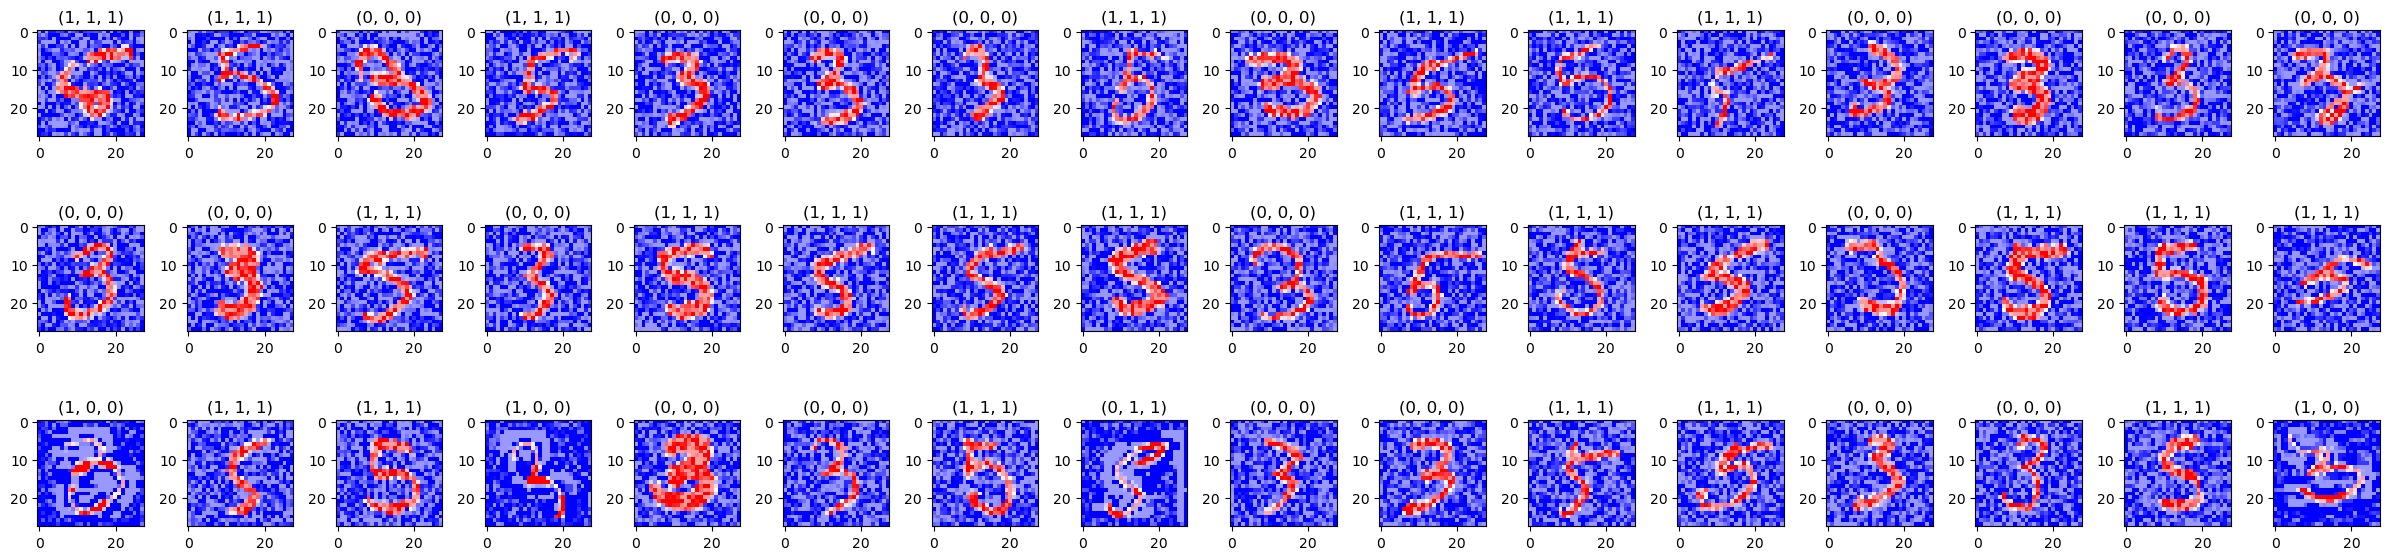

In [805]:
# model.to("cuda")
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=model.configure_optimizers(),
    input_shape=IMG_SHAPE,
    nb_classes=N_CLASSES,
)

# attack = FastGradientMethod(estimator=classifier) # eps=0.3
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.3, loss_type="difference_logits_ratio")#, nb_random_init=1, max_iter=100)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.3)#, nb_random_init=1, max_iter=100)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.2, eps_step=STEP_SIZE)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, loss_type="difference_logits_ratio")
x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().detach().numpy()))

predictions = classifier.predict(x_test.cpu().detach())
correct = np.argmax(predictions, axis=1) == y_test.numpy()
accuracy = np.sum(correct) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

predictions_adv = classifier.predict(x_test_adv)
correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))
hh.plot_example(x_test_adv, y_tests)

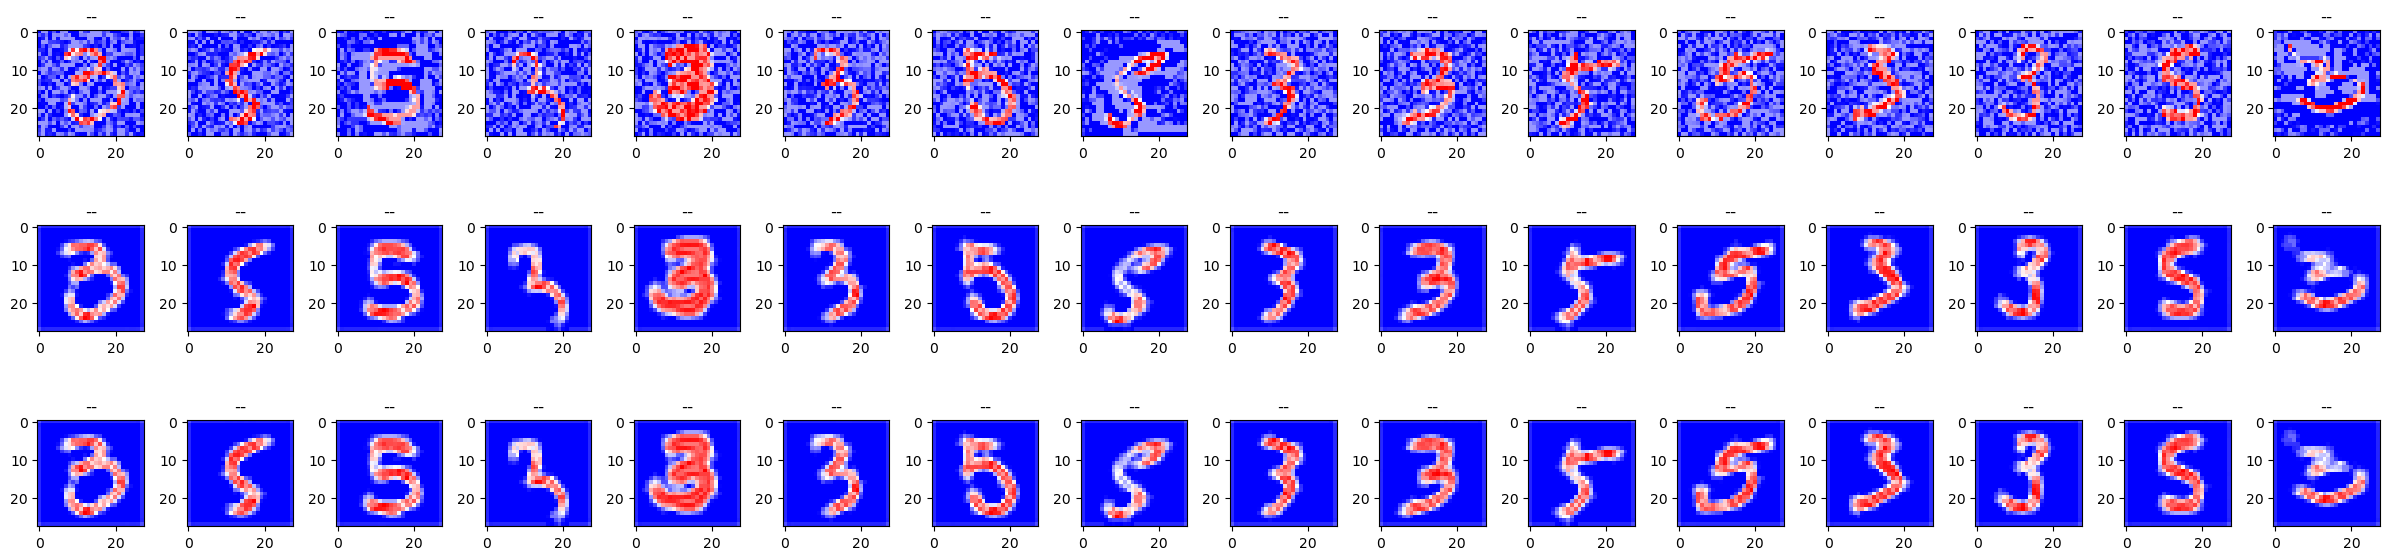

In [5381]:
# xx = x_test[32:48]
xx = x_test_adv[32:48].to(device)
preds = model.get_preds(xx).flatten(0, 1)
xx = bb.transform(xx)
in_x = xx

xx = den(xx)
# xx.shape
# xx = xx.flatten(0, 1)
pixel = xx
xx = torch.cat([in_x, pixel, preds], dim=0).detach().cpu()

# xx.shape
hh.plot_example(xx)

In [5382]:
adv_x = x_test_adv[32:48].to(device)
std_x = x_test[32:48].to(device)

# adv_repr = model.backbone.blocks[0](adv_x)
adv_repr = model.get_repr(adv_x)

# repr = model.get_repr(augmented_x)
# clean_repr = model.backbone.blocks[0](std_x)
clean_repr = model.get_repr(std_x)

adv_repr.shape

torch.Size([16, 2])

In [5383]:
def thresholdify(x, ticks, max_val = 1.0):
    xt = torch.stack([F.threshold(x, t, 0.0) for t in ticks], dim=0)
    xt = torch.min(xt, torch.ones_like(xt) * max_val)
    return xt

def ticks(num):
    return list(reversed([i/num for i in range(num)]))

ticks(10)

[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

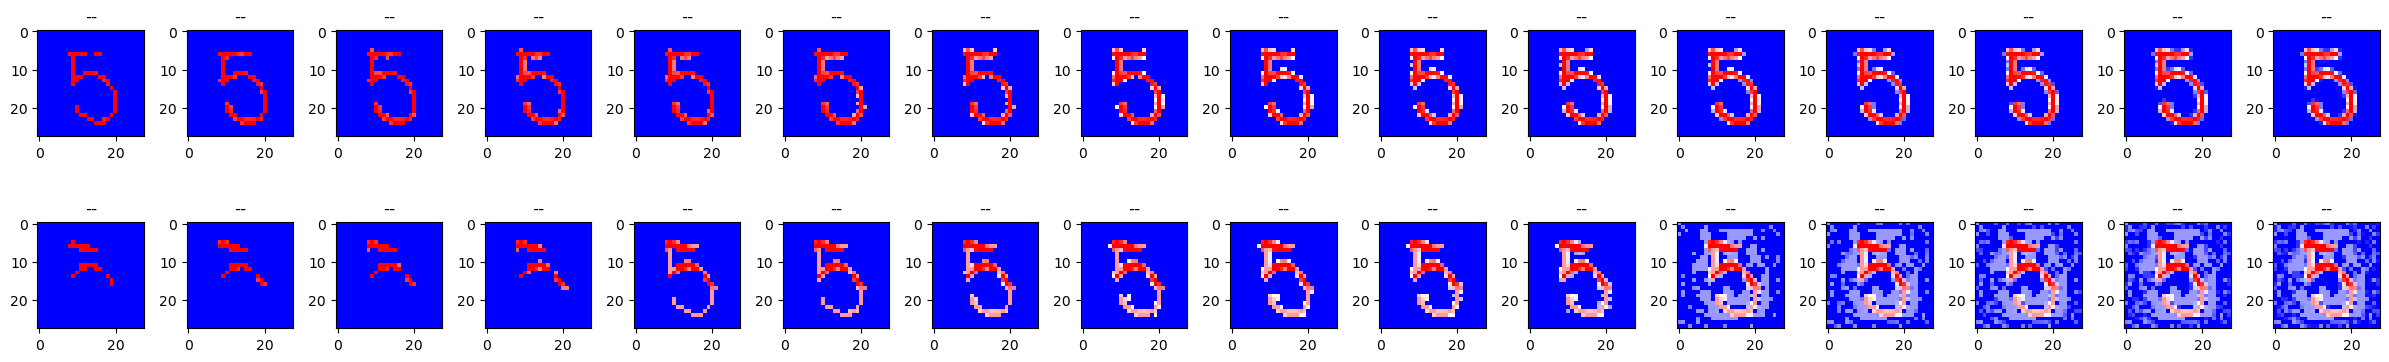

In [5125]:
# im_num = -4
# im_num = -5
# im_num = -9
im_num = -10
# im_num = -2
# im_num = -1
thresholds = ticks(16)
if im_num == -1:
    std_tx = thresholdify(std_x[im_num:], thresholds).flatten(0, 1)
    adv_tx = thresholdify(adv_x[im_num:], thresholds).flatten(0, 1)
else:
    std_tx = thresholdify(std_x[im_num:im_num+1], thresholds).flatten(0, 1)
    adv_tx = thresholdify(adv_x[im_num:im_num+1], thresholds).flatten(0, 1)

show = torch.cat([std_tx, adv_tx], dim=0)

hh.plot_example(show, n_col=len(thresholds), n_row=2, cmap='bwr')
# hh.plot_example(std_tx, n_col=len(thresholds), n_row=2)

In [5126]:

# tadv_repr = model.backbone.blocks[0](adv_tx)
tadv_repr = model.get_repr(adv_tx)

# tclean_repr = model.backbone.blocks[0](std_tx)
tclean_repr = model.get_repr(std_tx)

adv_repr.shape

torch.Size([16, 2])

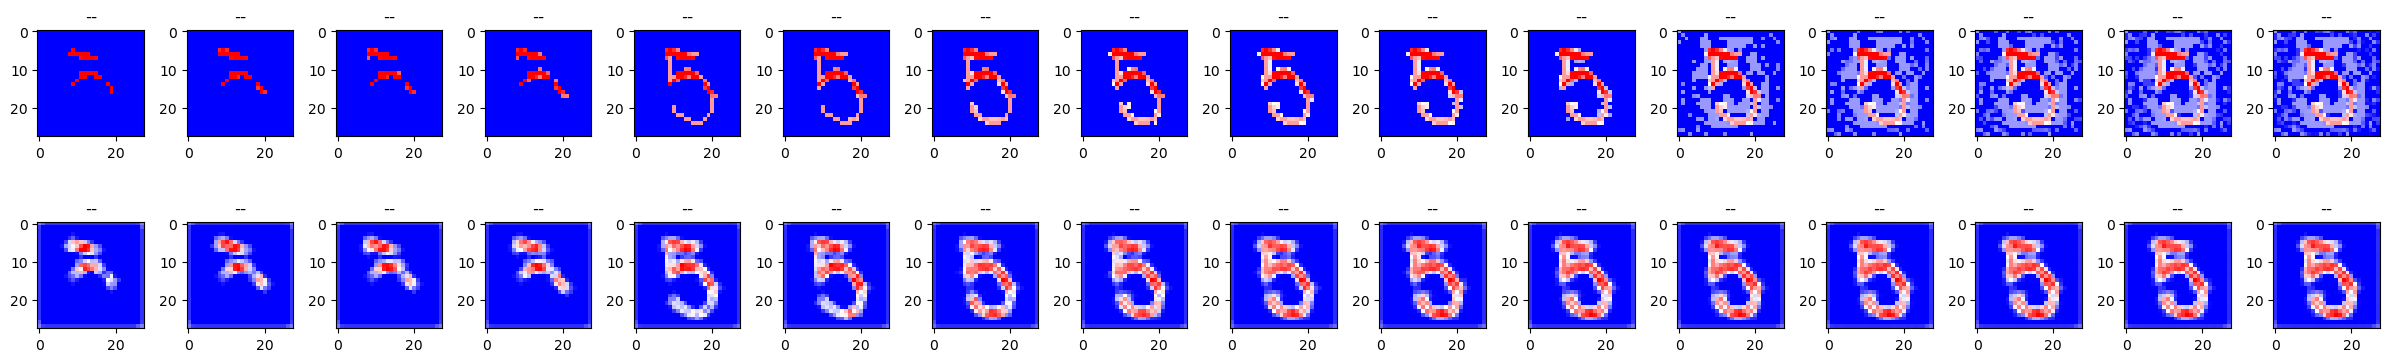

In [5127]:
xx = adv_tx
preds = model.get_preds(xx)
# res, preds = model.backbone.blocks[0](xx, return_preds=True)

preds = preds.detach()# * 100

n_row = preds.shape[0] + 1

preds = preds.flatten(0, 1)
# xx = model.normalize(xx)
preds = torch.cat([xx, preds], dim=0)
# preds = hh.to_show(preds)
# preds = preds.clip(0, 1).cpu()

# x.shape, n_row
hh.plot_example(preds, n_row=n_row, n_col=len(thresholds), cmap='bwr')

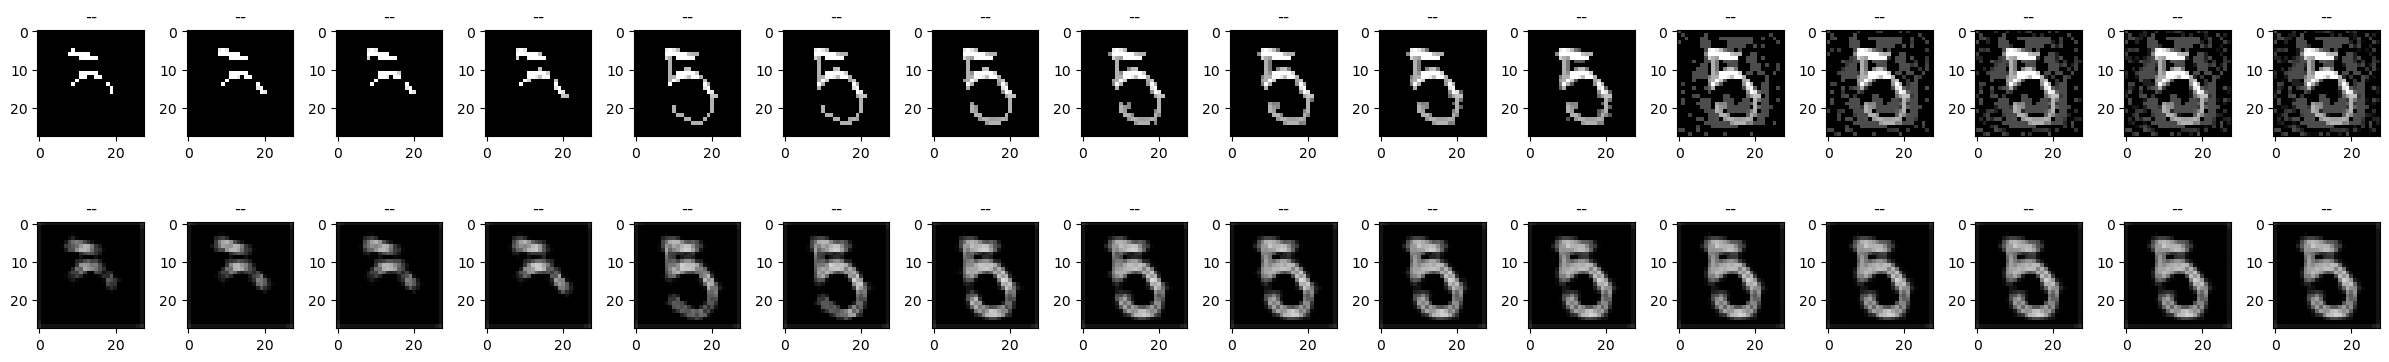

In [5128]:
show = hh.to_show(preds.repeat(1, 3, 1, 1))
hh.plot_example(show, n_row=n_row, n_col=len(thresholds), cmap='bwr')

In [5129]:
xx_std = x_test[32:48].to(device)
xx_adv = x_test_adv[32:48].to(device)

pp_adv = model.get_preds(xx_adv).mean(dim=0)#[0]
pp_std = model.get_preds(xx_std).mean(dim=0)#[0]

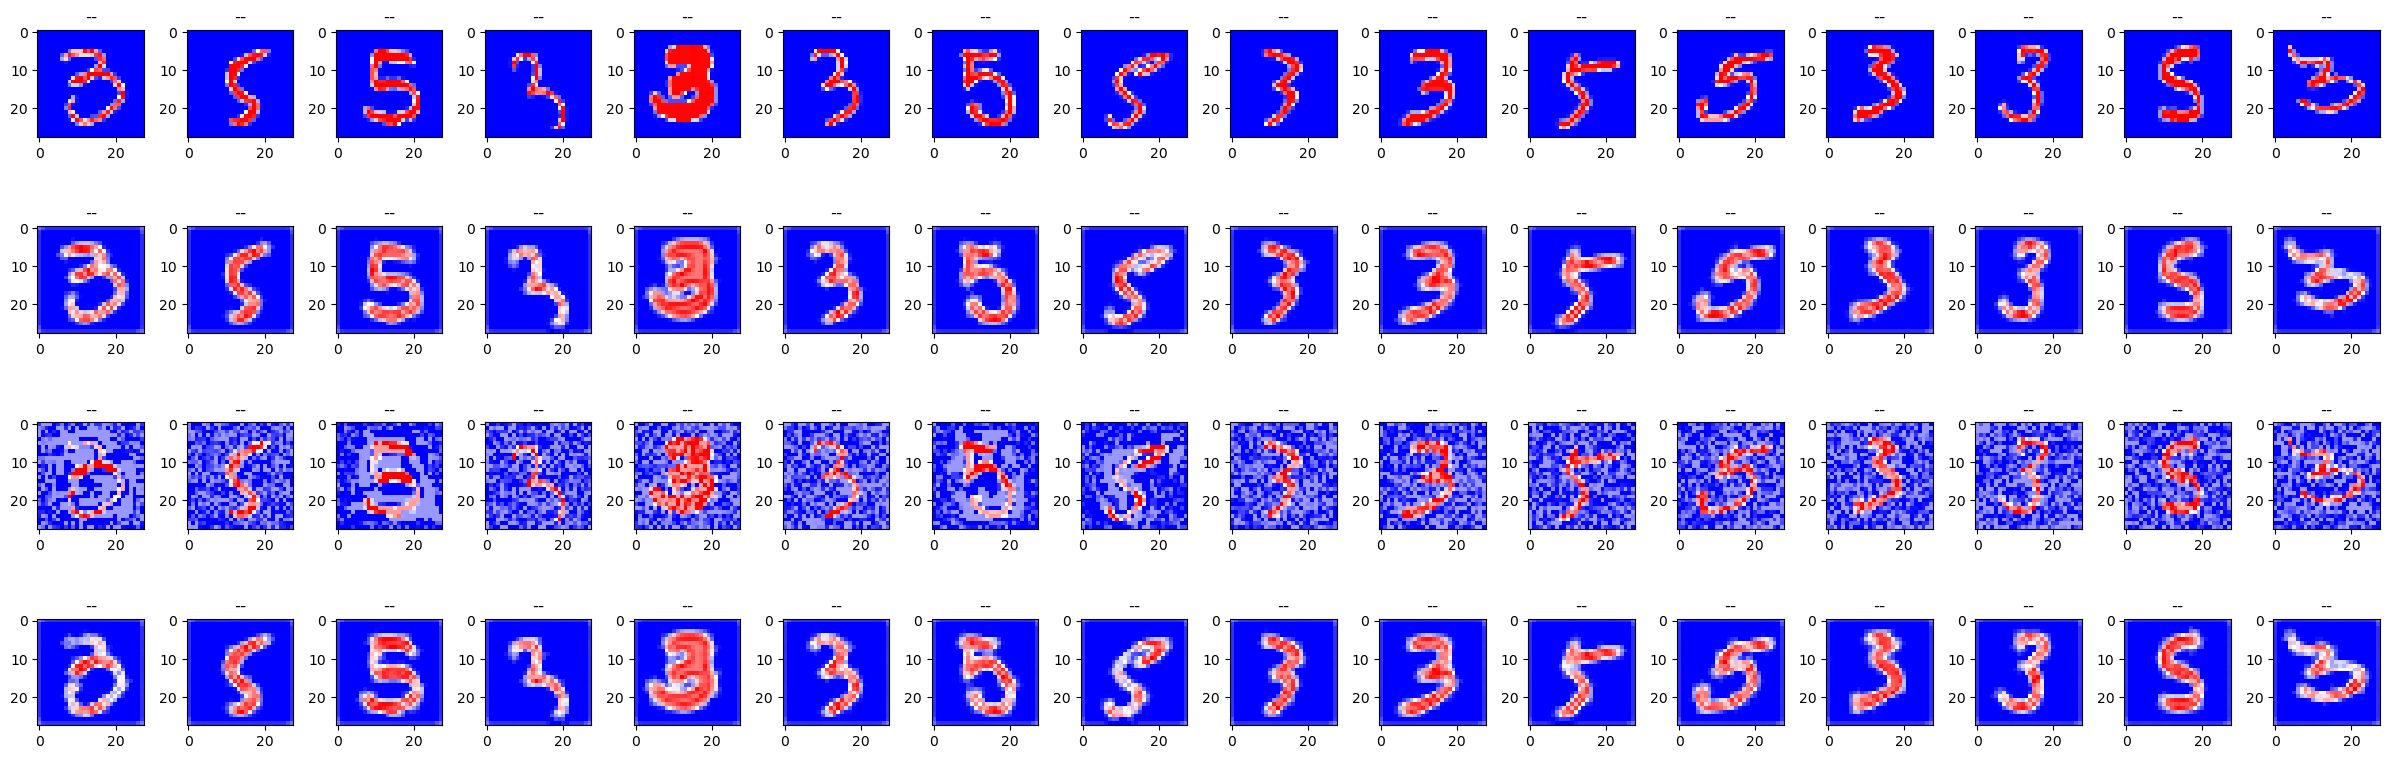

In [5130]:
xx = torch.cat([xx_std, xx_adv])
xxxx = torch.cat([xx_std, pp_std, xx_adv, pp_adv])
hh.plot_example(xxxx, n_row=4, cmap='bwr')
# show.shape

torch.Size([4, 1, 28, 28])


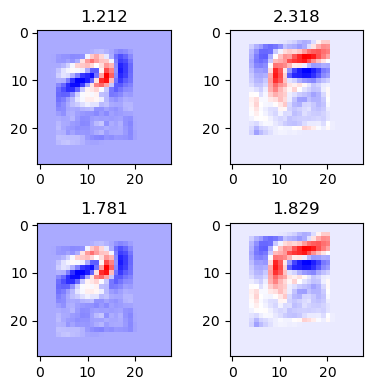

In [5131]:
im_std = xx_std[im_num]#[None]
im_adv = xx_adv[im_num]#[None]
ims = torch.stack([im_std, im_adv], dim=0)

x, xw = bb(ims, with_features=True)

show = xw.unflatten(-1, aff.inp_shape)
show = show.flatten(0, 1)
# show = show.flatten(0, 2)[:, None]
print(show.shape)
# show = show.sum(dim=1, keepdim=True)
# x = x.repeat_interleave(2, 1)

max_rows = 16
hh.plot_example(show, [round(e.item(), 3) for e in x.flatten()], n_col=2, n_row=2)

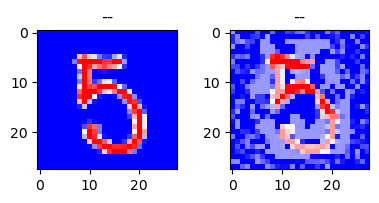

In [5132]:
hh.plot_example(ims, n_col=2, n_row=1)

In [5133]:
model.cls_head[1].weight

Parameter containing:
tensor([[ 1.9094, -1.7989],
        [-1.9094,  1.7989]], requires_grad=True)

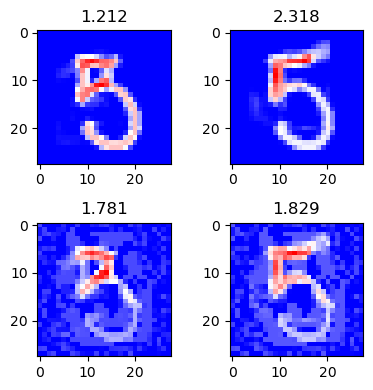

In [5134]:
# normalize_weight_(show)
ims_show = ims.repeat_interleave(2, dim=0) + 3*show.relu()
# ims_show = show
hh.plot_example(ims_show, [round(e.item(), 3) for e in x.flatten()], n_col=2, n_row=2)

In [5135]:
model.cls_head[1].weight

Parameter containing:
tensor([[ 1.9094, -1.7989],
        [-1.9094,  1.7989]], requires_grad=True)

In [5136]:
uf.max(), uf.min()

(tensor(0.2474, grad_fn=<MaxBackward1>),
 tensor(-0.1449, grad_fn=<MinBackward1>))

In [5137]:
res = model(xx)
res[[im_num-16, im_num]]
# res = model(ims)
# res

tensor([[-2.1257,  1.4482],
        [-0.1594, -0.5181]], grad_fn=<IndexBackward0>)

In [5138]:
res.softmax(dim=1)[[im_num-16, im_num]]

tensor([[0.0273, 0.9727],
        [0.5887, 0.4113]], grad_fn=<IndexBackward0>)

In [5139]:
ims.shape

torch.Size([2, 1, 28, 28])

In [4190]:
im_std[:, 0:12, 12:19].round(decimals=3)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5180, 0.8270, 0.5880, 0.1060, 0.0000, 0.0000, 0.0000],
         [0.9920, 0.6820, 1.0000, 0.2470, 0.0000, 0.0000, 0.0000],
         [0.2470, 0.3220, 0.9920, 0.2470, 0.0000, 0.0000, 0.0000],
         [0.2310, 0.9760, 0.9800, 0.2270, 0.0000, 0.0000, 0.0000],
         [0.7450, 0.9880, 0.4510, 0.0000, 0.2120, 0.0000, 0.0000]]])

In [4191]:
im_adv[:, 0:12, 12:19].round(decimals=3)

tensor([[[0.2450, 0.1500, 0.0000, 0.1680, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2930, 0.0000, 0.0000, 0.0000, 0.0840, 0.1000],
         [0.0320, 0.0000, 0.2580, 0.0000, 0.2650, 0.1900, 0.0000],
         [0.0000, 0.0000, 0.1500, 0.0670, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0520, 0.2020, 0.3000, 0.0000, 0.0000, 0.2370],
         [0.0000, 0.0000, 0.3000, 0.3000, 0.0000, 0.0000, 0.2630],
         [0.1760, 0.1100, 0.0940, 0.3000, 0.2720, 0.2060, 0.0000],
         [0.5620, 0.6930, 0.3490, 0.4060, 0.3000, 0.3000, 0.1330],
         [0.9020, 0.3820, 0.7000, 0.1100, 0.3000, 0.3000, 0.3000],
         [0.5470, 0.0220, 0.6920, 0.0000, 0.3000, 0.3000, 0.3000],
         [0.5310, 0.7270, 0.6800, 0.0000, 0.3000, 0.3000, 0.0000],
         [1.0000, 0.9100, 0.1510, 0.0000, 0.4190, 0.3000, 0.0000]]])

In [4192]:
avg = nn.AvgPool2d(3, stride=1, padding=(1, 1))
avg(im_adv)[:, 0:12, 12:19].round(decimals=3)
# avg(im_adv).shape

tensor([[[0.0770, 0.0770, 0.0680, 0.0190, 0.0280, 0.0200, 0.0410],
         [0.0800, 0.1090, 0.0970, 0.0770, 0.0790, 0.0710, 0.0620],
         [0.0530, 0.0810, 0.0850, 0.0820, 0.0670, 0.0710, 0.0680],
         [0.0490, 0.0770, 0.1140, 0.1380, 0.0910, 0.0770, 0.0750],
         [0.0790, 0.0780, 0.1520, 0.1470, 0.0740, 0.0560, 0.0830],
         [0.1040, 0.1040, 0.1840, 0.1960, 0.1530, 0.1090, 0.0790],
         [0.2890, 0.2540, 0.2840, 0.2580, 0.2320, 0.1640, 0.1000],
         [0.4990, 0.4410, 0.3490, 0.3140, 0.2770, 0.2350, 0.1610],
         [0.5880, 0.5390, 0.3730, 0.3510, 0.2570, 0.2810, 0.2150],
         [0.5470, 0.5760, 0.3680, 0.3430, 0.2120, 0.2670, 0.2000],
         [0.5670, 0.5850, 0.3540, 0.2830, 0.2130, 0.2470, 0.1430],
         [0.7700, 0.7220, 0.5410, 0.4270, 0.4450, 0.4550, 0.3350]]])

In [4193]:
df[0][:, 5:15, 18:25].round(decimals=3)

tensor([[[ 0.0900, -0.0020, -0.0570, -0.0720, -0.0540, -0.0610,  0.0000],
         [ 0.1430,  0.0230, -0.0810, -0.0880, -0.0680, -0.0640,  0.0000],
         [ 0.2000,  0.0100, -0.0870, -0.0960, -0.0610, -0.0620,  0.0000],
         [ 0.1780, -0.0230, -0.0910, -0.0720, -0.0510, -0.0480,  0.0000],
         [ 0.0870, -0.0590, -0.0730, -0.0610, -0.0400, -0.0380,  0.0000],
         [-0.0130, -0.0500, -0.0610, -0.0430, -0.0310, -0.0300,  0.0000],
         [-0.0280, -0.0270, -0.0250, -0.0200, -0.0150, -0.0130,  0.0000],
         [-0.0060, -0.0200,  0.0010,  0.0030,  0.0020,  0.0060,  0.0000],
         [-0.0080, -0.0000, -0.0080,  0.0150,  0.0080,  0.0120,  0.0000],
         [ 0.0040, -0.0280,  0.0010,  0.0040,  0.0250,  0.0140,  0.0000]]],
       grad_fn=<RoundBackward1>)

SquareAttack - restarts:   0%|          | 0/5 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 92.0%


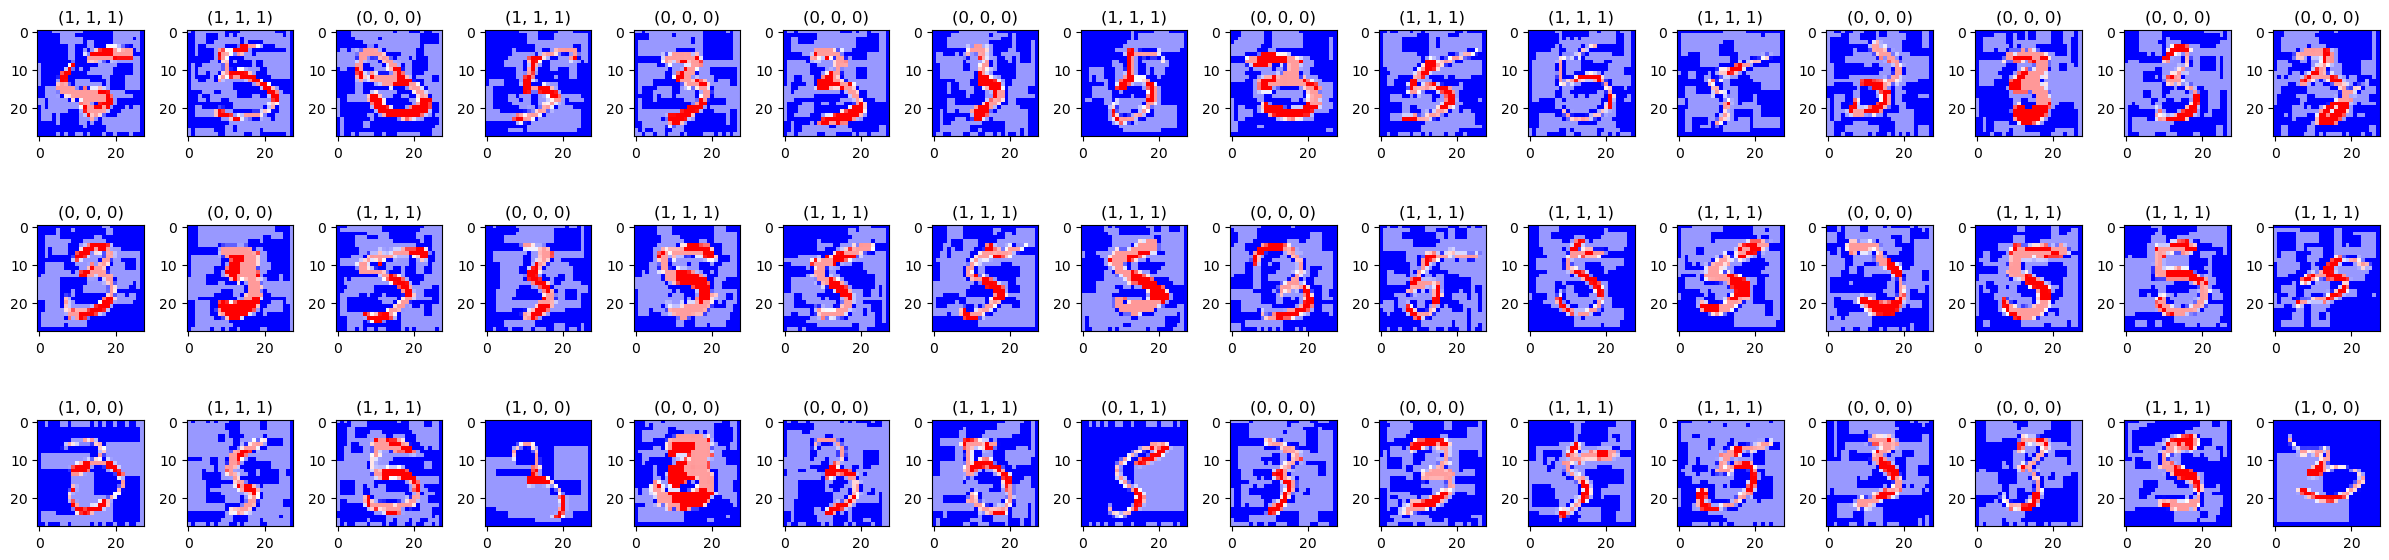

In [806]:
if True:
  classifier = PyTorchClassifier(
      model=model,
      clip_values=(0, 1),
      loss=torch.nn.CrossEntropyLoss(),
      optimizer=model.configure_optimizers(),
      input_shape=IMG_SHAPE,
      nb_classes=N_CLASSES,
  )

  # targeted = False
  # attack = AutoAttack(estimator=classifier, eps=1.5, norm=2, eps_step=0.1, targeted=targeted) # L2
  # attack = AutoAttack(estimator=classifier) # strongest
  # attack = AutoAttack(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
  attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=5000, eps=EPS, p_init=0.8, nb_restarts=5)
  x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().numpy()))

  predictions = classifier.predict(x_test.cpu())
  correct = np.argmax(predictions, axis=1) == y_test.numpy()
  accuracy = np.sum(correct) / len(y_test)
  print("Accuracy on clean test examples: {}%".format(accuracy * 100))

  predictions_adv = classifier.predict(x_test_adv)
  correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
  accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
  print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

  y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))
  hh.plot_example(x_test_adv, y_tests)

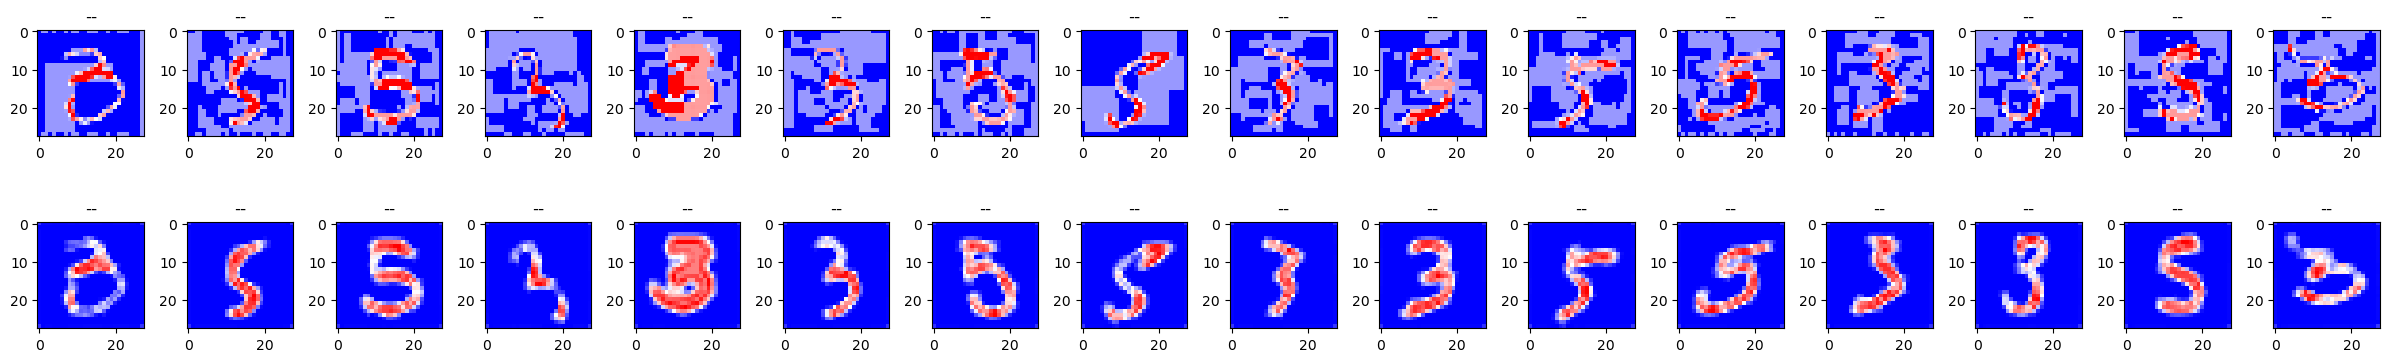

In [4890]:
xx = x_test_adv[32:48]
# xx = x_test[32:48].to(device)
# xx = augment(xx)
preds = model.get_preds(xx)

preds = preds.detach()

# xx = model.normalize(xx)
n_row = preds.shape[0] + 1

preds = preds.flatten(0, 1)
preds = torch.cat([xx, preds], dim=0)
preds = hh.to_show(preds)

# x.shape, n_row
hh.plot_example(preds, n_row=n_row)

Boundary attack:   0%|          | 0/16 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


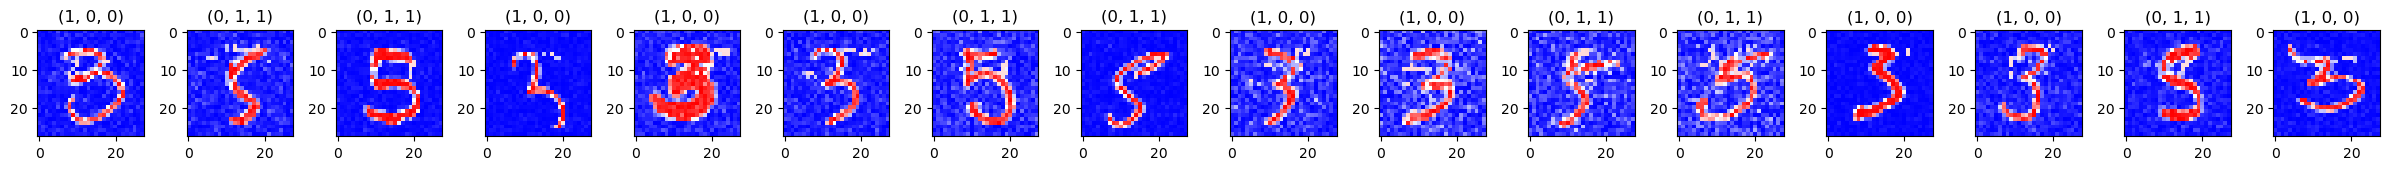

In [940]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=model.configure_optimizers(),
    input_shape=IMG_SHAPE,
    nb_classes=N_CLASSES,
)

x_test_small = x_test[32:48]
y_test_small = y_test[32:48]

targeted = False
attack = BoundaryAttack(estimator=classifier, targeted=targeted, min_epsilon=0.0, max_iter=1000)
# attack = BoundaryAttack(estimator=classifier, targeted=targeted, min_epsilon=0.0, max_iter=1000, init_size=100, sample_size=100, delta=0.1, epsilon=0.1)
x_test_adv = torch.from_numpy(attack.generate(x=x_test_small.cpu().numpy()))#, y=torch.fmod(y_test + 1, N_CLASSES))
# x_test_adv = attack.generate(x=x_test.numpy(), y=torch.fmod(y_test + 1, N_CLASSES))

predictions = classifier.predict(x_test_small.cpu())
correct = np.argmax(predictions, axis=1) == y_test_small.numpy()
accuracy = np.sum(correct) / len(y_test_small)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

predictions_adv = classifier.predict(x_test_adv)
correct_adv = np.argmax(predictions_adv, axis=1) == y_test_small.numpy()
accuracy_adv = np.sum(correct & correct_adv) / len(y_test_small)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

# hh.plot_example(x_test_adv, list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1))), n_row=5, n_col=1)
y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test_small.numpy(), np.argmax(predictions, axis=1)))
hh.plot_example(x_test_adv, y_tests, n_row=1)

tensor(-0.3549, grad_fn=<MinBackward1>) tensor(0.5166, grad_fn=<MaxBackward1>)


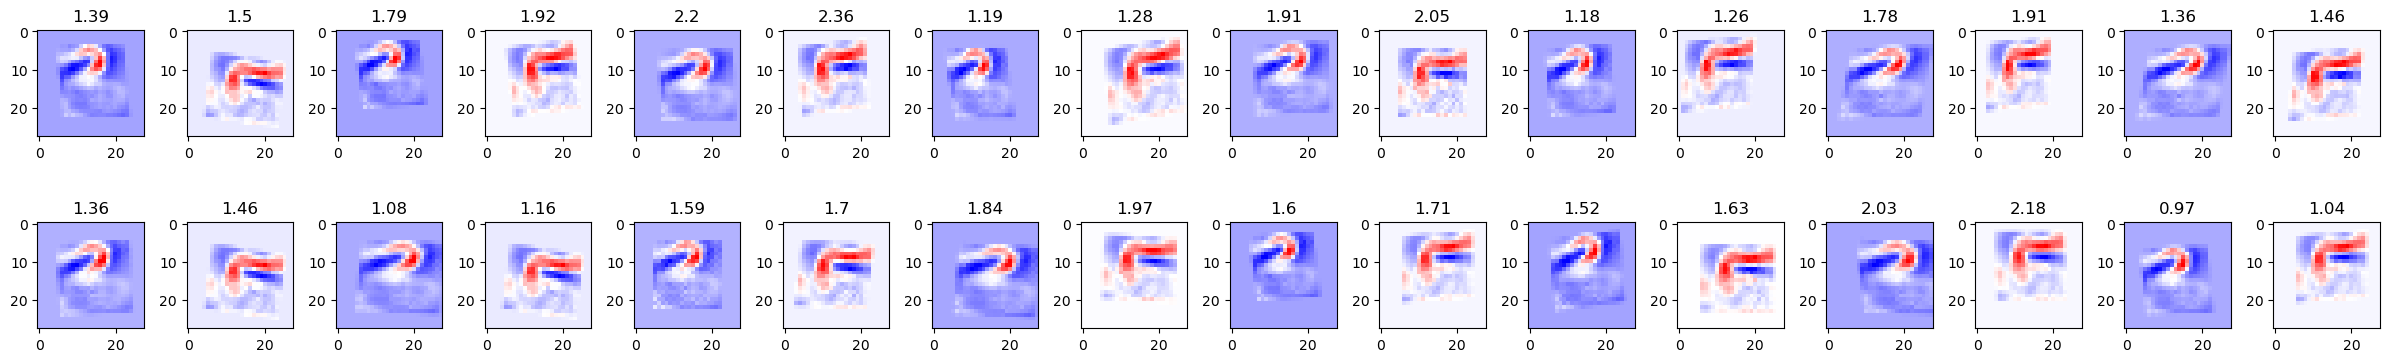

In [795]:
xx = x_test_adv[:16].to(device)
xx = bb[:2](xx)
x, xw = bb[2](xx, with_features=True)

show = xw.unflatten(-1, IMG_SHAPE).flatten(0, 1)
# show = xw.unflatten(-1, IMG_SHAPE).flatten(0, 1)
print(show.min(), show.max())

max_rows = 16
hh.plot_example(show, [round(e.item(), 2) for e in x.flatten()], n_col=16, n_row=min(max(show.shape[0]//16, 2), max_rows))

In [796]:
bb[3].weight, bb[3].bias

(Parameter containing:
 tensor([[ 1.9243, -1.7931],
         [-1.9243,  1.7931]], requires_grad=True),
 None)

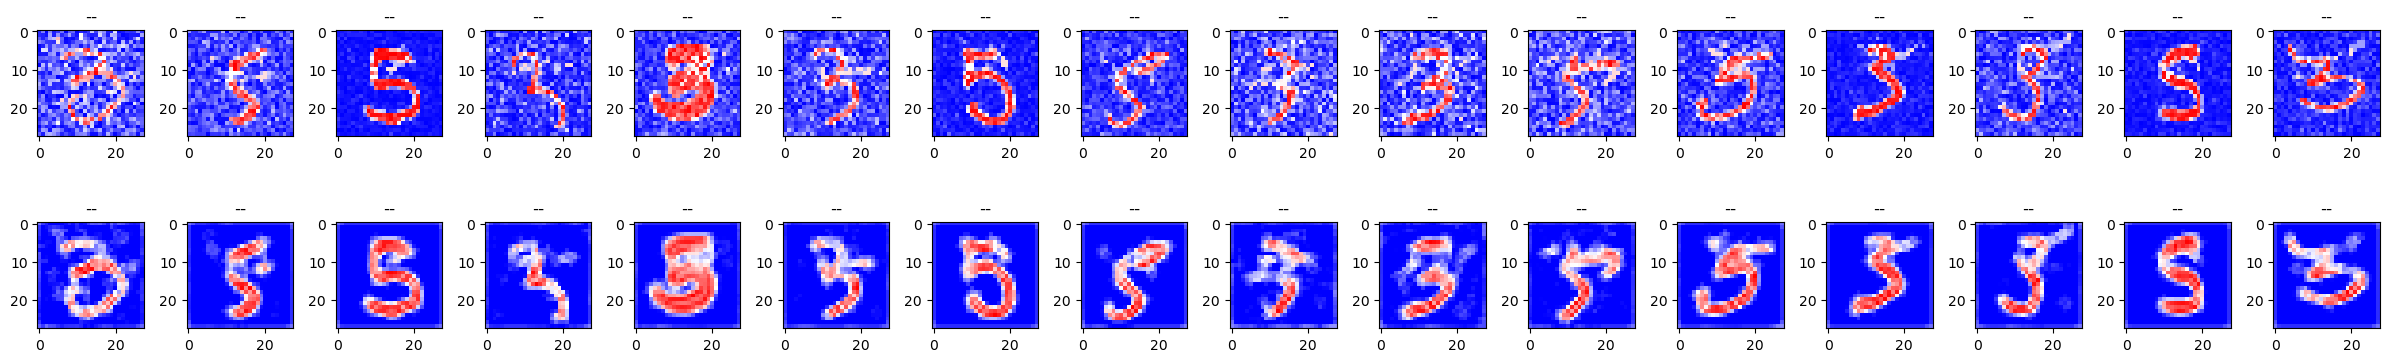

In [5115]:
xx = x_test_adv[:48]
# xx = x_test_adv[16:32]
# xx = x_test_adv[32:48]
# xx = x_test[32:48].to(device)
# xx = augment(xx)
preds = model.get_preds(xx)

preds = preds.detach()

# xx = model.normalize(xx)
n_row = preds.shape[0] + 1

preds = preds.flatten(0, 1)
preds = torch.cat([xx, preds], dim=0)
preds = hh.to_show(preds)

# x.shape, n_row
hh.plot_example(preds, n_row=2)

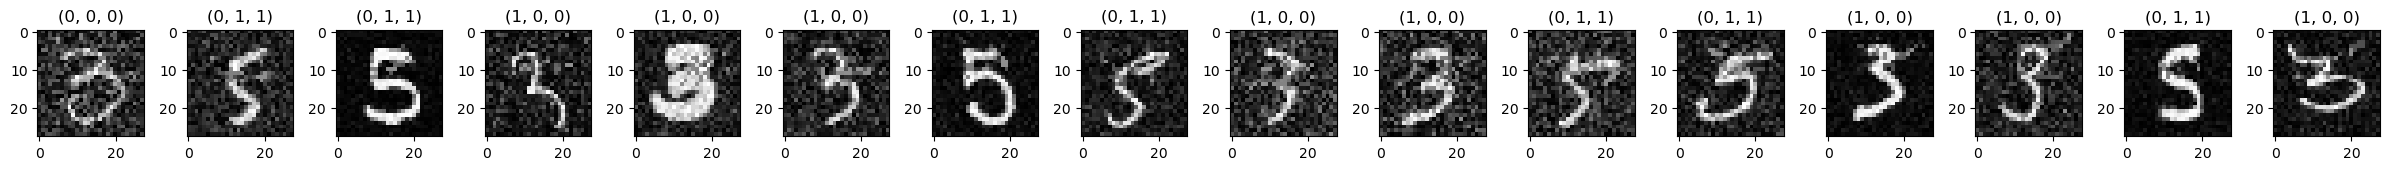

In [5116]:
y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test_small.numpy(), np.argmax(predictions, axis=1)))
hh.plot_example(x_test_adv, y_tests, cmap="gray", n_row=1)

In [620]:
(x_test_adv - x_test_small).max()

tensor(0.6445)

In [4897]:
model(x_test).shape

torch.Size([50, 2])

In [5391]:
# n_samples = 2000
n_samples = 400
n_skip = 0
# n_samples = 200
# n_samples = 10000
# iter_ = iter(datamodule.val_dataloader(n_samples))
iter_ = iter(datamodule.test_dataloader(n_samples))
# iter_ = iter(datamodule.train_dataloader(n_samples)) # TRAIN!
for _ in range(n_skip):
    next(iter_)
x_test, y_test = next(iter_)
x_test = x_test.to(device)

In [5392]:
x_test.shape

torch.Size([400, 1, 28, 28])

In [5406]:
class DLRAdapter(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        x = torch.cat([x, -100*torch.ones_like(x[:, 0])[:, None]], dim=1)
        return x

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/13 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/12 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/12 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/12 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/12 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 98.5%
Accuracy on adversarial test examples: 91.5%


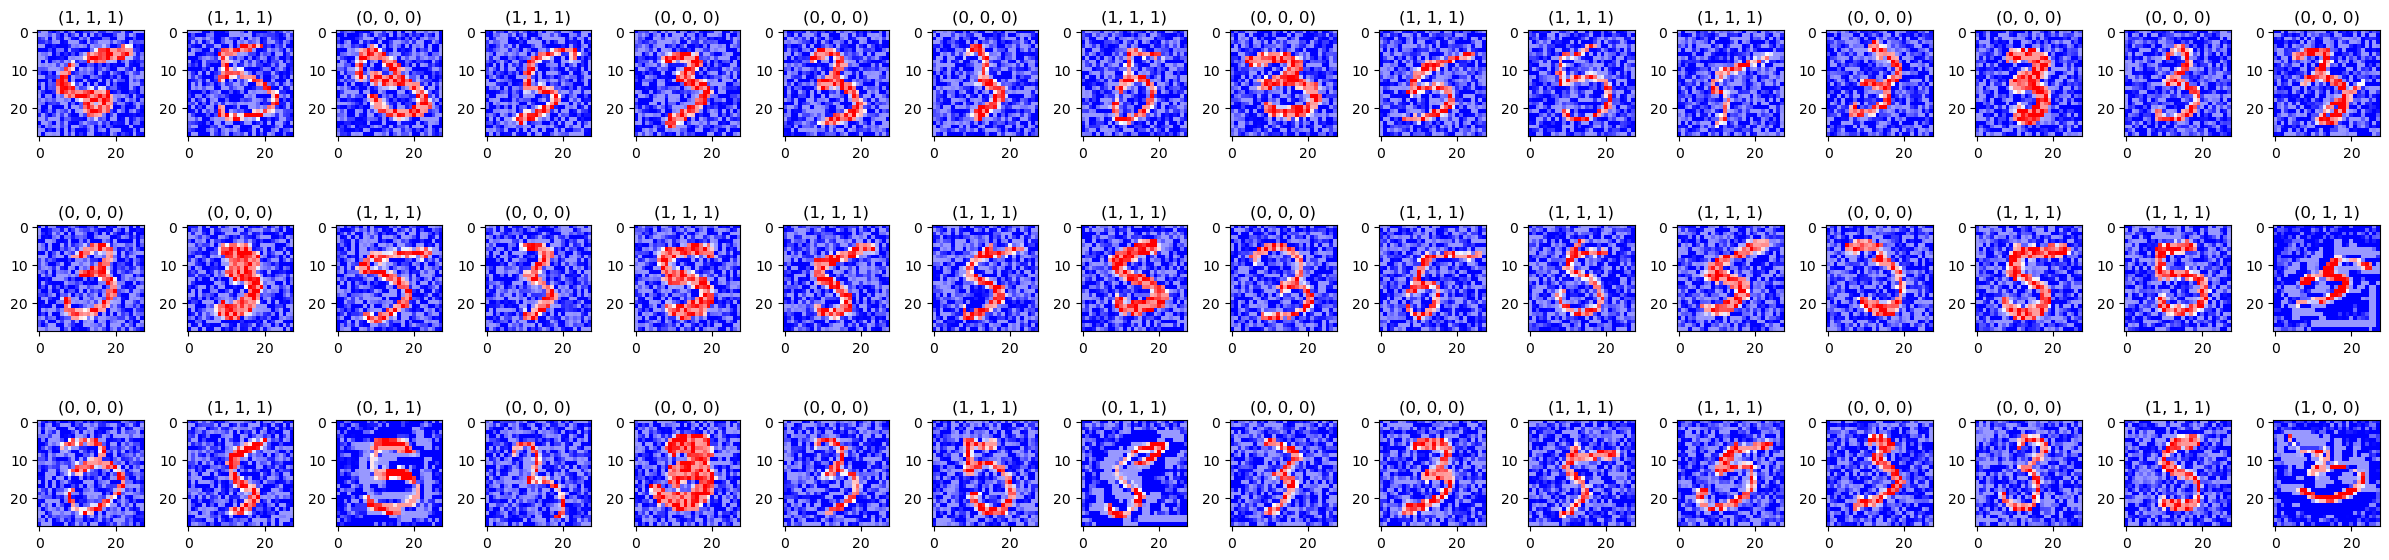

In [5407]:
# model.to("cuda")
adapted_model = DLRAdapter(model)
# adapted_model = model

classifier = PyTorchClassifier(
    model=adapted_model,
    clip_values=(0, 1),
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=model.configure_optimizers(),
    input_shape=IMG_SHAPE,
    nb_classes=N_CLASSES,
)

# attack = FastGradientMethod(estimator=classifier) # eps=0.3
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.3, loss_type="difference_logits_ratio")#, nb_random_init=1, max_iter=100)
attack = AutoProjectedGradientDescent(estimator=classifier)#, nb_random_init=1, max_iter=100)
# attack = AutoAttack(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=0.2, eps_step=STEP_SIZE)
# attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, loss_type="difference_logits_ratio")
x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().detach().numpy()))

predictions = classifier.predict(x_test.cpu().detach())
correct = np.argmax(predictions, axis=1) == y_test.numpy()
accuracy = np.sum(correct) / len(y_test)
print("Accuracy on clean test examples: {}%".format(accuracy * 100))

predictions_adv = classifier.predict(x_test_adv)
correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))
hh.plot_example(x_test_adv, y_tests)

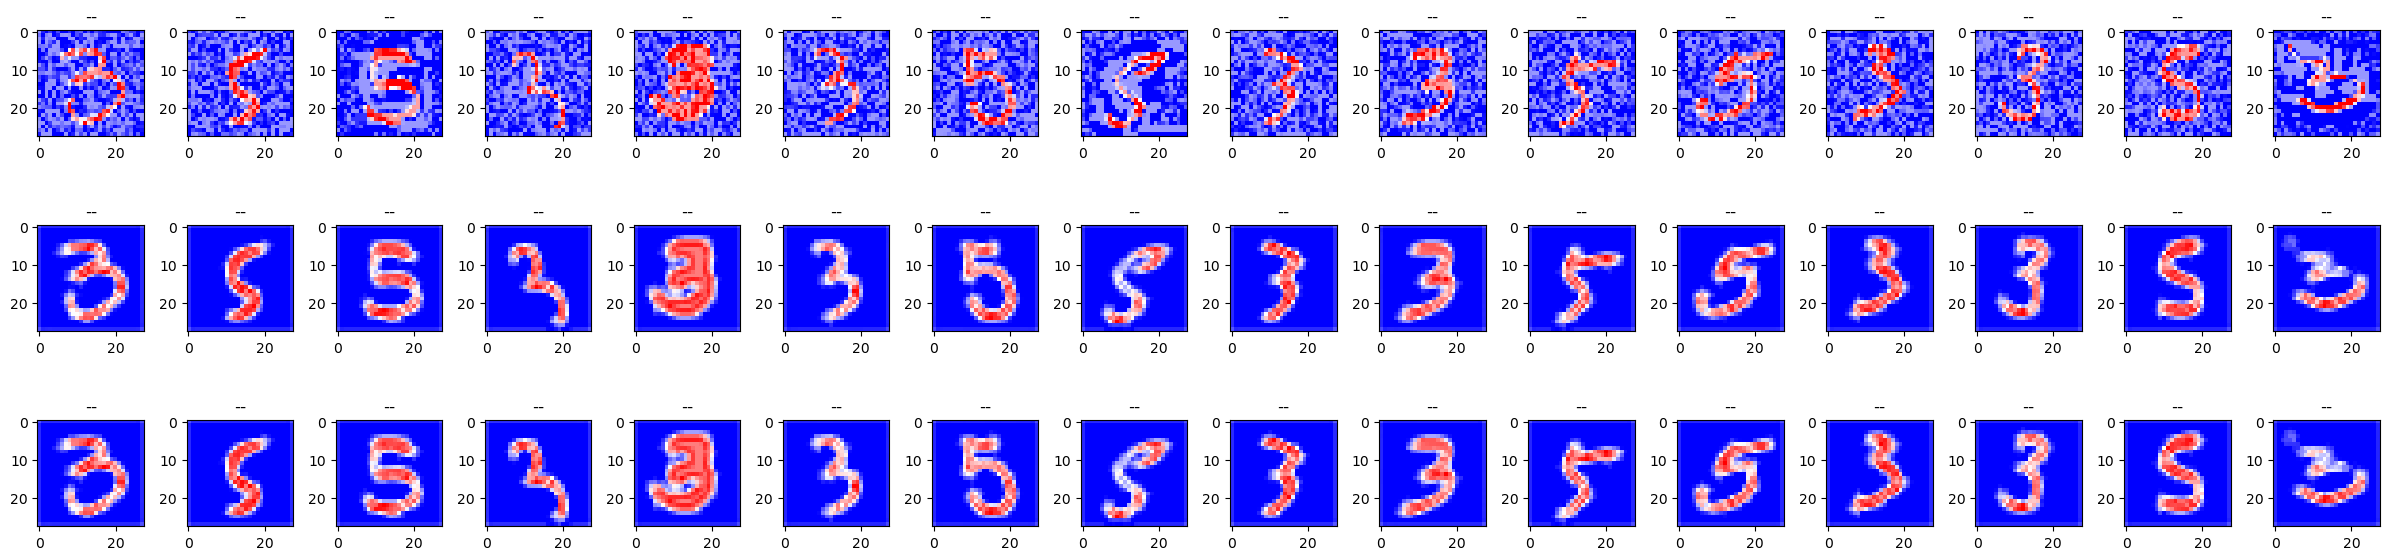

In [5408]:
# xx = x_test[32:48]
xx = x_test_adv[32:48].to(device)
preds = model.get_preds(xx).flatten(0, 1)
xx = bb.transform(xx)
in_x = xx

xx = den(xx)
# xx.shape
# xx = xx.flatten(0, 1)
pixel = xx
xx = torch.cat([in_x, pixel, preds], dim=0).detach().cpu()

# xx.shape
hh.plot_example(xx)

In [5409]:
confidence, preds = model(x_test_adv).softmax(dim=1).max(dim=1)#[list(range(y_test.shape[0])), y_test]
len(confidence)

400

In [5416]:
torch.tensor([1., 5., -10.]).softmax(dim=0).round(decimals=3), torch.tensor([1., 5.]).softmax(dim=0).round(decimals=3)

(tensor([0.0180, 0.9820, 0.0000]), tensor([0.0180, 0.9820]))

In [5410]:
miss_conf = confidence[preds != y_test]
corr_conf = confidence[preds == y_test]
max_miss_conf, avg_miss_conf = miss_conf.max(), miss_conf.mean()
max_miss_conf, avg_miss_conf, corr_conf.max(), corr_conf.mean()

(tensor(0.9667, grad_fn=<MaxBackward1>),
 tensor(0.6687, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<MaxBackward1>),
 tensor(0.9905, grad_fn=<MeanBackward0>))

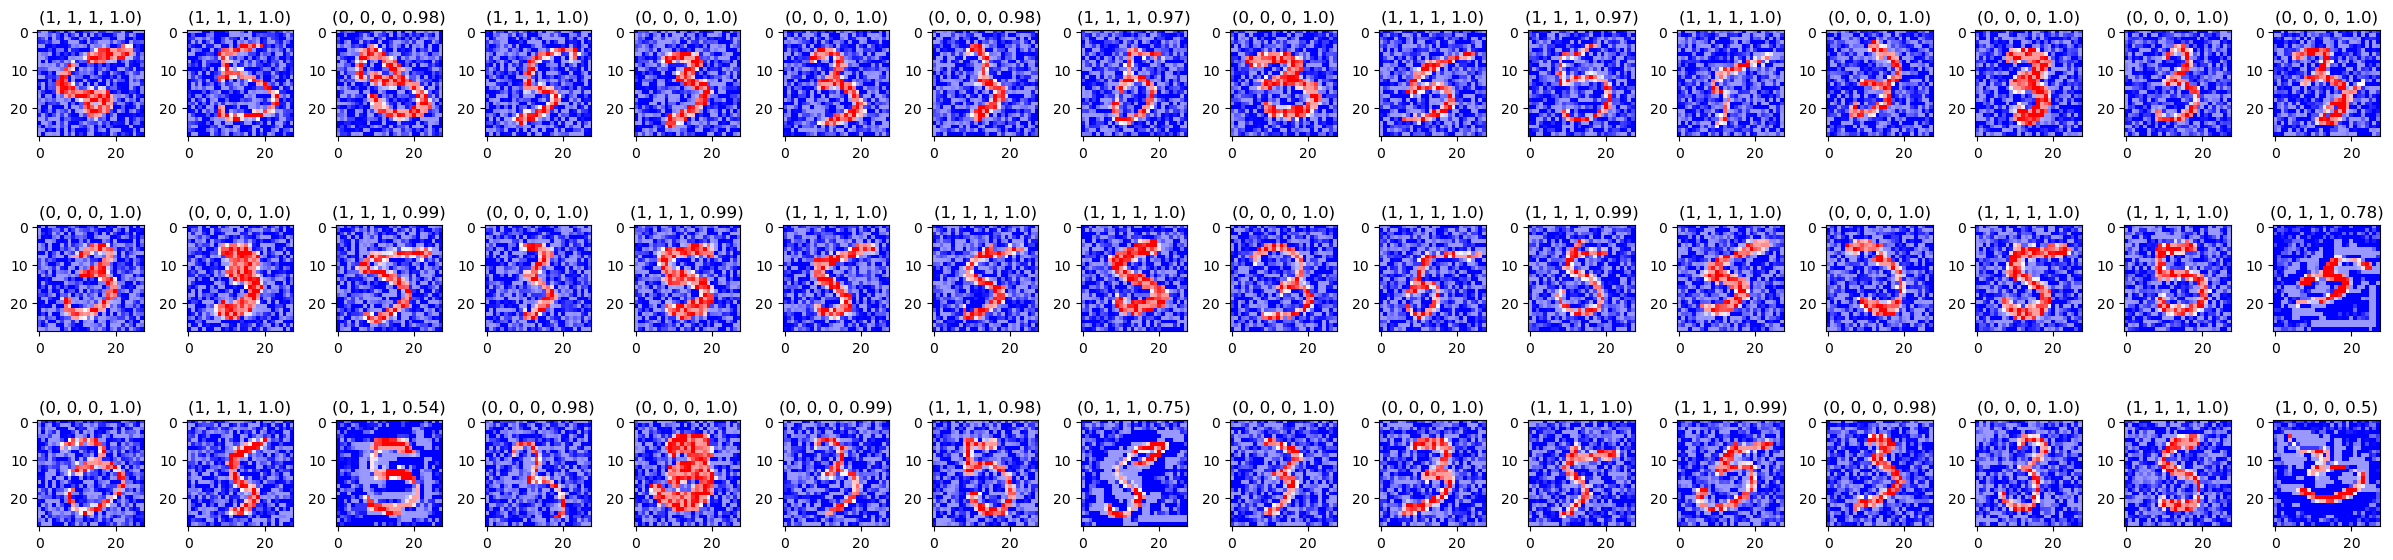

In [5411]:
conf = list(round(e.item(), ndigits=2) for e in confidence)
y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1), conf))
hh.plot_example(x_test_adv, y_tests)

In [4931]:
len(datamodule.test_dataloader().dataset)

1902